<p align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens"/> </p>

<br>

---

<h3 align="center" > 
  Bachelor Thesis
</h3>

<h1 align="center" > 
  Entity Resolution in Dissimilarity Spaces <br>
  Implementation notebook
</h1>

---

<h3 align="center"> 
 <b>Konstantinos Nikoletos</b>
</h3>

<h4 align="center"> 
 <b>Supervisors:<br> Dr. Alex Delis</b>,  Professor NKUA <br> <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University

</h4>
<br>
<h4 align="center"> 
Athens
</h4>
<h4 align="center"> 
January 2021 - Ongoing
</h4>


---

# __Implementation__

## __0.0 Install components__

In [23]:
!pip install editdistance

In [24]:
!pip install pandas
import pandas as pd
print(pd.__version__)

1.0.1


In [25]:
!pip install pandas_read_xml

  Using cached urllib3-1.26.5-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11


ERROR: requests 2.22.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: botocore 1.12.189 has requirement urllib3<1.26,>=1.20, but you'll have urllib3 1.26.5 which is incompatible.


In [26]:
!pip install requests

  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.5
    Uninstalling urllib3-1.26.5:
      Successfully uninstalled urllib3-1.26.5


ERROR: pandas-read-xml 0.3.1 has requirement urllib3>=1.26.3, but you'll have urllib3 1.25.11 which is incompatible.


## __0.1 Import libraries__

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk


from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from nltk import jaccard_distance
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import stats 
from scipy.spatial.distance import euclidean
from matplotlib.patches import Rectangle

plt.style.use('seaborn-whitegrid') # plot style

## __Final model__









In [64]:
class RankedWTAHash:

  def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', ngramms=3, similarityThreshold=None, maxOnly=None ):
    '''
      Constructor
    '''
    self.max_numberOf_clusters = max_numberOf_clusters
    self.pairDictionary = dict()
    self.max_editDistance = max_editDistance
    self.windowSize = windowSize
    self.S_set = None 
    self.S_index = None 
    self.similarityThreshold = similarityThreshold
    self.maxOnly = maxOnly
    self.metric = metric
    self.min_numOfNodes = min_numOfNodes
    self.similarityVectors = similarityVectors
    self.number_of_permutations = number_of_permutations
    self.distanceMetric = distanceMetric
    self.distanceMetricEmbedding = distanceMetricEmbedding
    self.ngramms = ngramms
  
  def fit(self, X):
    """
      Fit the classifier from the training dataset.
      Parameters
      ----------
      X : Training data.
      Returns
      -------
      self : The fitted classifier.
    """
    print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

    if isinstance(X, list):
      input_strings = X
    else:
      input_strings = list(X)

    # print(input_strings)
    self.initialS_set = np.array(input_strings,dtype=object)
    self.S_set = np.array(input_strings,dtype=object)
    if self.distanceMetric == 'jaccard':    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(data[i]), n=self.ngramms))
        
    # print(self.S_set)

    self.S_index = np.arange(0,len(input_strings),1)

    # print("\n\nString positions are:")
    # print(self.S_index)
    # print("\n")

    print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
    print("\n-> Finding prototypes and representatives of each cluster:")
    prototypes_time = time.time()
    self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
    print("\n- Prototypes selected")
    self.embeddingDim = self.prototypeArray.size
    print(self.prototypeArray)
    for pr in self.prototypeArray:
        print(pr," -> ",self.initialS_set[pr])
    print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
    prototypes_time = time.time() - prototypes_time
    print("\n# Finished in %.6s secs" % (prototypes_time))
    print("\n")

    print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
    print("\n-> Creating Embeddings:")
    embeddings_time = time.time()
    self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
    print("- Embeddings created")
    print(self.Embeddings)
    embeddings_time = time.time() - embeddings_time
    print("\n# Finished in %.6s secs" % (embeddings_time))
    print("\n")


    print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
    print("\n-> Creating WTA Buckets:")
    wta_time = time.time()
    self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize,self.embeddingDim, self.number_of_permutations)
    print("- WTA buckets: ")
    for key in self.buckets.keys():
      print(key," -> ",self.buckets[key])
    print("\n- WTA number of buckets: ", len(self.buckets.keys()))
    print("\n- WTA RankedVectors after permutation:")
    print(self.rankedVectors)
    wta_time = time.time() - wta_time
    print("\n# Finished in %.6s secs" % (wta_time))
    print("\n")

    print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
    print("\n-> Similarity checking:")
    similarity_time = time.time()

    if self.similarityVectors == 'ranked':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
    elif self.similarityVectors == 'initial':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)      
    else:
      warnings.warn("similarityVectors: Available options are ranked,initial")
    print("- Similarity matrix (all values compared):")
    print(self.similarityProb_matrix)
    print("- Similarity mapping in a matrix")
    print(self.mapping_matrix)
    similarity_time = time.time() - similarity_time
    print("\n# Finished in %.6s secs" % (similarity_time))
    print("\n#####################################################################\n#                    .~ End of training ~.                          #\n#####################################################################\n")

    return self

  def EditDistance(self, str1,str2,verbose=False):
      if verbose:
        if str1 == None:
            print("1")
        elif str2 == None:
            print("2")
        print("-> "+str(str1))
        print("--> "+str(str2))
        print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))
      
      
      # NOTE: Duplicates inside the dictionary     

      if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
        return self.pairDictionary[(str1,str2)]
      else:
        # if verbose:
        # print("++++++++++")
        # print(str1,str2)
        # print(self.S_set[str1],self.S_set[str2])
        # print("++++++++++")
        if self.distanceMetric == 'edit':
            distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
        elif self.distanceMetric == 'jaccard':
            distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
        else:
            warnings.warn("Available metrics for space creation: edit, jaccard ")
        self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
        return distance

  #####################################################################
  # 1. Prototype selection algorithm                                  #
  #####################################################################

  '''
  Clustering_Prototypes(S,k,d,r,C) 
  The String Clustering and Prototype Selection Algorithm
  is the main clustering method, that takes as input the intial strings S, 
  the max number of clusters to be generated in k,
  the maximum allowable distance of a string to join a cluster in var d
  and returns the prototype for each cluster in array Prototype
  '''
  def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):
      
      # ----------------- Initialization phase ----------------- #
      i = 0
      j = 0
      C = np.empty([S.size], dtype=int)
      r = np.empty([2,k],dtype=object)

      Clusters = [ [] for l in range(0,k)]

      for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
          while j < k :       # iteration through clusters, for all clusters
              if r[0][j] == None:      # case empty first representative for cluster j
                  r[0][j] = S[i]   # init cluster representative with string i
                  C[i] = j         # store in C that i-string belongs to cluster j
                  Clusters[j].append(S[i])
                  break
              elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative 
                  r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string 
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              else:
                  j += 1
          i += 1

      # ----------------- Prototype selection phase ----------------- #
          
      Projections = np.empty([k],dtype=object)
      Prototypes = np.empty([k],dtype=int)
      sortedProjections = np.empty([k],dtype=object)

      Projections = []
      Prototypes = []
      sortedProjections = []

      if verbose:
          print("- - - - - - - - -")
          print("Cluster array:")
          print(C)
          print("- - - - - - - - -")
          print("Represantatives array:")
          print(r)
          print("- - - - - - - - -")  
          print("Clusters:")
          print(Clusters)
          print("- - - - - - - - -")  

      new_numofClusters = k

      # print("\n\n\n****** Prototype selection phase *********") 
      prototype_index = 0
      for j in range(0,k,1):
          
          # IF small cluster
          # print("Len ",len(Clusters[j]))
          if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
            new_numofClusters-=1
            continue

          Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))         
          # print(Projections[prototype_index])
          sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
          
          
          Prototypes.append(self.Median(sortedProjections[prototype_index]))
          # print(Prototypes[prototype_index])

          prototype_index += 1

      # print("\n****** END *********\n")

      return np.array(Prototypes),new_numofClusters


  def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):
      # print("here")
      # print(clusterSet)
      # print(right_rep, left_rep)

      distances_vector = dict()

      if len(clusterSet) > 2:
        rep_distance     = self.EditDistance(right_rep,left_rep)
                 
        for str_inCluster in range(0,len(clusterSet)): 
          if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
            # print(clusterSet[str_inCluster],right_rep,left_rep)
            right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
            left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])
            
            if rep_distance == 0: 
              distances_vector[clusterSet[str_inCluster]] = 0
            else:
              distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
              distances_vector[clusterSet[str_inCluster]] = distance
      
      else:
#         print("set: ",clusterSet)
#         print("left: ",left_rep)
#         print("right: ",right_rep)
        if left_rep != None and right_rep == None:
          distances_vector[left_rep] = left_rep
          # print("l")
        elif right_rep != None and left_rep == None:
          distances_vector[right_rep] = right_rep
          # print("r")
        elif left_rep == None and right_rep == None:
          return None
        elif left_rep != None and right_rep != None:
          distances_vector[right_rep] = right_rep
          distances_vector[left_rep]  = left_rep
      # print(distances_vector)
      return distances_vector

  def Median(self, distances):    
      '''
      Returns the median value of a vector
      '''
      keys = list(distances.keys())
      if keys == 1:
        return keys[0]

      # print(distances)
      keys = list(distances.keys())
      # print(keys)
      median_position = int(len(keys)/2)
      # print(median_position)
      median_value = keys[median_position]

      return median_value
  

  
  #####################################################################
  #       2. Embeddings based on the Vantage objects                  #
  #####################################################################

  '''
  CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
  '''
  def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):
      
      # ------- Distance computing ------- #     
      vectors = []
      for s in tqdm(range(0,S.size)):
          string_embedding = []
          for p in range(0,VantageObjects.size): 
              if VantageObjects[p] != None:
                  string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))
              
          # --- Ranking representation ---- #
          ranked_string_embedding = stats.rankdata(string_embedding, method='dense')
          
          # ------- Vectors dataset ------- #
          vectors.append(ranked_string_embedding)
      
      return np.array(vectors)
      

  '''
  DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
  '''
  def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):
      
      if distanceMetricEmbedding == 'l_inf':
          max_distance = None

          for pp in range(0,VantageObjects.size):
              if VantageObjects[pp] != None:
                  string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                  VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                  abs_diff = abs(string_distance-VO_distance)

                  # --- Max distance diff --- #        
                  if max_distance == None:
                      max_distance = abs_diff
                  elif abs_diff > max_distance:
                      max_distance = abs_diff
          return max_distance
    
      elif distanceMetricEmbedding == 'edit':
          return self.EditDistance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'jaccard':
          return jaccard_distance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'euclidean':
          return euclidean(S[s],VantageObjects[p])
      else:
          warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")
        

  def dropNone(array):
      array = list(filter(None, list(array)))
      return np.array(array)

  def topKPrototypes():
      return

  #####################################################################
  #                 3. Similarity checking                            # 
  #####################################################################

  def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):
    
#     print(buckets)
#     print(vectors)
    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]
    mapping_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.int8)
    self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
    mapping = {}

    # Loop for every bucket
    for bucketid in tqdm(buckets.keys()):
      bucket_vectors = buckets[bucketid]
      numOfVectors = len(bucket_vectors)
      
      print(bucket_vectors)
      # For every vector inside the bucket
      for v_index in range(0,numOfVectors,1):
        v_vector_id = bucket_vectors[v_index]
        # Loop to all the other
        for i_index in range(v_index+1,numOfVectors,1):
          i_vector_id = bucket_vectors[i_index]
#           print('v_vector_id: ',v_vector_id,'i_vector_id: ',i_vector_id)
#           print(vectors[v_vector_id], " | ",vectors[i_vector_id])

          if vectorDim == 1:
            warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
            metric = 'kendal'

          if metric == None or metric == 'kendal':  # Simple Kendal tau metric
            similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'customKendal':  # Custom Kendal tau
            numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
            similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
          elif metric == 'jaccard':
            similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
          elif metric == 'cosine':
            similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
          elif metric == 'pearson':
            similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearman':
            similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
          else:
            warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,cosine,spearman,pearson")
            
          self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob
#           print("pr: ",self.similarityProb_matrix[v_vector_id][i_vector_id],similarity_prob)
          # if v_vector_id == 0:
          #   print(v_vector_id, i_vector_id," : ",similarity_prob )        
          if similarity_prob > threshold:
            if v_vector_id not in mapping.keys():
              mapping[v_vector_id] = []
            mapping[v_vector_id].append(i_vector_id)  # insert into mapping
            mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix

    
    return mapping, mapping_matrix

  #####################################################################
  #                        4. WTA Hashing                             # 
  #####################################################################

  def WTA(self,vectors,K,inputDim, number_of_permutations):
    '''
      Winner Take All hash - Yagnik
      .............................

      K: window size
    '''
    newVectors = []
    buckets = dict()

    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]

    if vectorDim < K:
      K = vectorDim
      warnings.warn("Window size greater than vector dimension")
      
    C = np.zeros([numOfVectors,number_of_permutations], dtype=int)
    
#     X_new = np.array(vectors)
    
    permutation_dimension = inputDim
    for permutation_index in range(0,number_of_permutations,1):
        theta = np.random.permutation(permutation_dimension)
        i=0;j=0;
#         print(newVectors)
        for v_index in range(0,numOfVectors,1):
#           print(v_index)
          
          if permutation_index == 0:
#             print("Before: ",vectors[v_index])
            X_new = self.permuted(vectors[v_index],theta)
            newVectors.append(X_new[:K])
          else:
#             print("Before: ",newVectors[v_index])
#             print(theta[:K])
            X_new = self.permuted(newVectors[v_index],theta)
            newVectors[v_index] = X_new[:K]
          
              
          X_new = X_new[:K]
#           print("After: ",X_new)
#           print("X_new: ",X_new)
          index_max = max(range(len(X_new)), key=X_new.__getitem__)
#           print("- ",index_max)
          c_i = index_max

          for j in range(0,K,1):
            if X_new[j] > X_new[c_i]:
              c_i = j

#           print("-> ",c_i)
          C[i][permutation_index] = c_i
#           print(C)
          
          i+=1
        permutation_dimension = K

    for c,i in zip(C,range(0,numOfVectors,1)):
        buckets = self.bucketInsert(buckets,str(c),i)
#     print(C)
#     print(buckets)
    return C,buckets,np.array(newVectors,dtype=np.intp)

  def permuted(self,vector,permutation):
    permuted_vector = [vector[x] for x in permutation]
    return permuted_vector 

  def bucketInsert(self,buckets,bucket_id,item):
    if bucket_id not in buckets.keys():
      buckets[bucket_id] = []
    buckets[bucket_id].append(item)

    return buckets


### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [3]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=False ):

  print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
  true_matrix = csr_matrix(true_matrix)
  # print(true_matrix)
  predicted_matrix =  csr_matrix(predicted_matrix)
  # print(predicted_matrix)

  acc = 100*accuracy_score(true_matrix, predicted_matrix)
  f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
  recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
  precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

  print("Accuracy:  %3.2f %%" % (acc))
  print("F1-Score:  %3.2f %%" % (f1))
  print("Recall:    %3.2f %%" % (recall))
  print("Precision: %3.2f %%" % (precision))

  # results_dataframe = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
  # results_dataframe.loc[len(results_dataframe)+1] = [acc,precision,recall,f1]

  if with_classification_report:
    print(classification_report(true_matrix, predicted_matrix))

  print('\n\n')
  return acc,f1,precision,recall


### GridSearch function

In [4]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors','Accuracy','Precision','Recall','F1','Time'])

    for n1 in tqdm(max_numberOf_clusters):
        for n2 in tqdm(max_editDistance):
            for n3 in tqdm(similarityThreshold):
                for n4 in tqdm(windowSize):
                    for n5 in tqdm(metric):
                        for n6 in tqdm(similarityVectors):
                            print("-------------------------")
                            print('max_numberOf_clusters: ',n1)
                            print('max_editDistancez: ',n2)
                            print('similarityThreshold: ',n3)
                            print('windowSize: ',n4)
                            print('metric: ',n5)
                            print('similarityVectors: ',n6)
                            print("-------------------------")
                            start = time.time()
                            model = RankedWTAHash(
                              max_numberOf_clusters= n1,
                              max_editDistance= n2,
                              windowSize= n4,
                              similarityThreshold= n3,
                              maxOnly= False,
                              metric=n5,
                              similarityVectors=n6
                            )
                            model = model.fit(data)
                            exec_time = time.time() - start
                            acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                            results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,acc,precision,recall,f1,exec_time]

    return results_dataframe


# __Evaluation__

## __CoRA__ - New

### Load from Drive

In [5]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

### Jupyter load

In [6]:
import os
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")

In [7]:
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
xml_dataframe = cora
xml_dataframe['@id'] = pd.to_numeric(xml_dataframe['@id']).subtract(1)
xml_dataframe.head(30)

@id                                             author  \
0     0  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
1     1  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
2     2  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
3     3  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
4     4  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
5     5  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
6     6  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
7     7  M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...   
8     8                                     C. Ray Asfahl.   
9     9               Steve Benford and Lennart E. Fahlen.   
10   10                         Benford, S., and Fahln, L.   
11   11  Benford, S., Bowers, J., Fahln, L., Greenhalgh...   
12   12  Benford, S., Bowers, J., Fahlen, L.E., Greenha...   
13   13  Benford, S., Bowers, J., Fahlen, L.E., Greenha...   
14   14  Steve Benford, John Bowers, Lennart Fahlen, Ch...   
15   15              Brown, D. F., Moura, H. & Watt, D. A.   
16   16              Brown, D. F., Moura, H. & Watt, D. A.   
17   17    D. F. Brown, H. Moura, and D. A. Watt. Actress:   
18   18  B. Buth, K.-H. Buth, M. Franzle, B. v. Karger,...   
19   19                                   B. Buth et. al.,   
20   20                                   B. Buth et. al.,   
21   21                                   B. Buth et. al.,   
22   22  Bettina Buth, Karl-Heinz Buth, Martin Franzle,...   
23   23             [Carlson, C.; L.E.Fahln., Conklin, J.]   
24   24                                      Cramer, N. L.   
25   25  Daelemans, W., Van den Bosch, A., and Weijters...   
26   26                                                NaN   
27   27                                                NaN   
28   28                                                NaN   
29   29             Dempster, A., Laird, N., and Rubin, D.   

                                                title  \
0                                    Inganas and M.R.   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8                Robots and Manufacturing Automation.   
9   A spatial model of interaction in large virtua...   
10  Viewpoints, Actionpoints and Spatial Frames fo...   
11  User Embodiment in Collaborative Virtual Envir...   
12  User Embodiment in Collaborative Virtual Envir...   
13  User Embodiment in Collaborative Virtual Envir...   
14   Networked Virtual realitty and Cooperative Work.   
15  Actress: an action semantics directed compiler...   
16  Actress: an action semantics directed compiler...   
17   an action semantics directed compiler generator.   
18  Provably correct compiler development and impl...   
19          Provably Correct Compiler Implementation,   
20          Provably Correct Compiler Implementation,   
21          Provably Correct Compiler Implementation,   
22  Provably correct compiler development and impl...   
23  [Integrated CSCW Tools Within a Shared 3D Virt...   
24  A representation for the adaptive generation o...   
25  [IG-tree: A variant of IBL. submitted. Availab...   
26  An investigation of niche and species formatio...   
27  An investigation of niche and species formatio...   
28  An investigation of niche and species formatio...   
29  Maximum likelihood from incomplete data via th...   

                                        journal    volume           pages  \
0                     Andersson, J Appl. Phys.,       76,            893,   
1                                J Appl. Phys.,       76,            893,   
2                                J Appl. Phys.,       76,            893,   
3    

### Import true values


In [8]:
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)
cora_glod_30 = cora_gold.head(47)
cora_glod_30

id1  id2
0     0    1
1     0    2
2     0    3
3     0    4
4     0    5
5     0    6
6     0    7
7     1    2
8     1    3
9     1    4
10    1    5
11    1    6
12    1    7
13    2    3
14    2    4
15    2    5
16    2    6
17    2    7
18    3    4
19    3    5
20    3    6
21    3    7
22    4    5
23    4    6
24    4    7
25    5    6
26    5    7
27    6    7
28   11   12
29   11   13
30   12   13
31   15   16
32   15   17
33   16   17
34   18   19
35   18   20
36   18   21
37   18   22
38   19   20
39   19   21
40   19   22
41   20   21
42   20   22
43   21   22
44   26   27
45   26   28
46   27   28

### Preprocess

In [9]:
def preprocess(row):

    paper_str = " ".join(row)
    paper_str = paper_str.lower()
    paper_str = paper_str.replace("\n", " ").replace("/z", " ").replace("[","").replace("]","").replace(",", " ")

    return str(paper_str)

### Shuffle data

In [10]:
shuffled_df = xml_dataframe.head(15).sample(frac=1).reset_index(drop=True)
# shuffled_df

### Creating dataset with 30 records

In [11]:
def cora_createDataset(xml_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(xml_dataframe.iterrows()):
        index_to_id_dict[int(row['@id'])] = i

        rawStr = []
        for field in fields:    # NAN
            if not (keepNone == False and field == None):
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(xml_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.head(47).iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
            print('here')
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

    print(cluster_dict)
    print(clusters)
    return rawStr_col,sameEntities_dictionary, trueValues_matrix, clusters


# fields = ['author', 'title', 'journal', 'volume', 'pages', 'date', '#text',
#        'publisher', 'address', 'note', 'booktitle', 'editor', 'booktile',
#        'tech', 'institution', 'Pages', 'year', 'type', 'month']

fields = ['author', 'title', 'journal']

data, true_labels, true_matrix, clusters = cora_createDataset(xml_dataframe.head(30), true_values, fields)

cora_glod_30['cluster_id'] = clusters

here
here
here
here

{0: {0, 1, 2, 3, 4, 5, 6, 7}, 1: {11, 12, 13}, 2: {16, 17, 15}, 3: {18, 19, 20, 21, 22}, 4: {26, 27, 28}}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4]


C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
# groups = cora_glod_30.groupby(cora_glod_30.cluster_id)
# groups.groups
groups = cora_glod_30.groupby('cluster_id').agg(list)
groups['cluster_items'] = groups['id1']+groups['id2']
groups['cluster_items'][0]

clusters = []
for _,r in groups.iterrows():
    l = list(set(x for x in r['cluster_items']))
    print(l)
#     l = l.sort()
    clusters.append(sorted(l))
clusters

[0, 1, 2, 3, 4, 5, 6, 7]
[11, 12, 13]
[16, 17, 15]
[18, 19, 20, 21, 22]
[26, 27, 28]


[[0, 1, 2, 3, 4, 5, 6, 7],
 [11, 12, 13],
 [15, 16, 17],
 [18, 19, 20, 21, 22],
 [26, 27, 28]]

In [13]:
cora_glod_30

id1  id2  cluster_id
0     0    1           0
1     0    2           0
2     0    3           0
3     0    4           0
4     0    5           0
5     0    6           0
6     0    7           0
7     1    2           0
8     1    3           0
9     1    4           0
10    1    5           0
11    1    6           0
12    1    7           0
13    2    3           0
14    2    4           0
15    2    5           0
16    2    6           0
17    2    7           0
18    3    4           0
19    3    5           0
20    3    6           0
21    3    7           0
22    4    5           0
23    4    6           0
24    4    7           0
25    5    6           0
26    5    7           0
27    6    7           0
28   11   12           1
29   11   13           1
30   12   13           1
31   15   16           2
32   15   17           2
33   16   17           2
34   18   19           3
35   18   20           3
36   18   21           3
37   18   22           3
38   19   20           3
39   19   21           3
40   19   22           3
41   20   21           3
42   20   22           3
43   21   22           3
44   26   27           4
45   26   28           4
46   27   28           4

## Dataset inspection

#### String length

In [14]:
data_length = [ len(x) for x in data ]
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))

Average length: 112
Min length: 55
Max length: 209


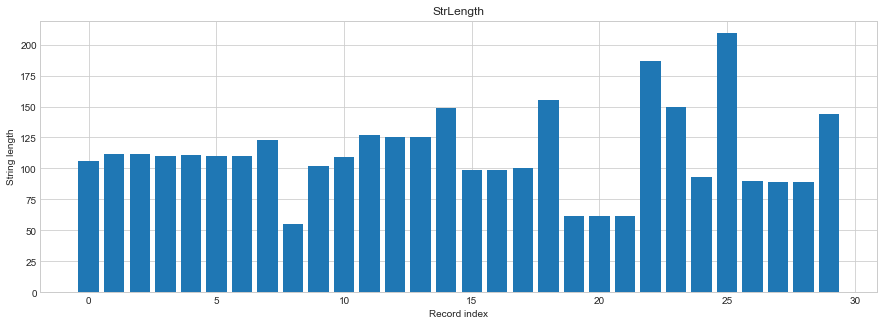

In [15]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

## Jaccard VS Edit distance variance

In [16]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot of images
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [17]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

{(' ', 'i', 's'), ('p', 'l', 'e'), ('r', 'a', 'm'), ('e', 'x', 'a'), ('m', 's', '!'), ('h', 'i', 's'), ('b', 'i', 'g'), ('i', 'g', 'r'), ('n', 'd', ' '), ('m', 's', ' '), ('a', 'n', 'd'), (' ', 'b', 'i'), ('r', 'i', 'g'), ('l', 'e', ' '), (' ', 'a', 'n'), ('m', 'p', 'l'), ('T', 'h', 'i'), ('d', ' ', 't'), (' ', 'o', 'f'), ('o', 'f', ' '), ('a', 'm', 'm'), ('m', 'm', 's'), ('s', ' ', 'a'), ('n', ' ', 'e'), ('x', 'a', 'm'), ('e', ' ', 'o'), ('t', 'r', 'i'), ('f', ' ', 'b'), (' ', 'e', 'x'), ('s', ' ', 'i'), ('g', 'r', 'a'), ('a', 'n', ' '), (' ', 't', 'r'), ('i', 's', ' '), ('a', 'm', 'p')}
{('of', 'bigramms', 'and'), ('bigramms', 'and', 'trigramms'), ('example', 'of', 'bigramms'), ('This', 'is', 'an'), ('and', 'trigramms', '!'), ('an', 'example', 'of'), ('is', 'an', 'example')}
0.0
0.0


In [18]:
ed_matrix  = np.zeros((len(data),len(data)), dtype=np.int)
jc2_matrix = np.zeros((len(data),len(data)), dtype=np.float)
jc3_matrix = np.zeros((len(data),len(data)), dtype=np.float)
js2_matrix = np.zeros((len(data),len(data)), dtype=np.float)
js3_matrix = np.zeros((len(data),len(data)), dtype=np.float)

for i in range(0,len(data),1):
    for j in range(0,len(data),1):
        if i != j:
            ed_matrix[i][j]  = editdistance.eval(data[i],data[j])
            jc3_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=3)),set(nltk.ngrams(data[j], n=3)))
            js3_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=3)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=3)))
            jc2_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=2)),set(nltk.ngrams(data[j], n=2)))
            js2_matrix[i][j] = 1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=2)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=2)))

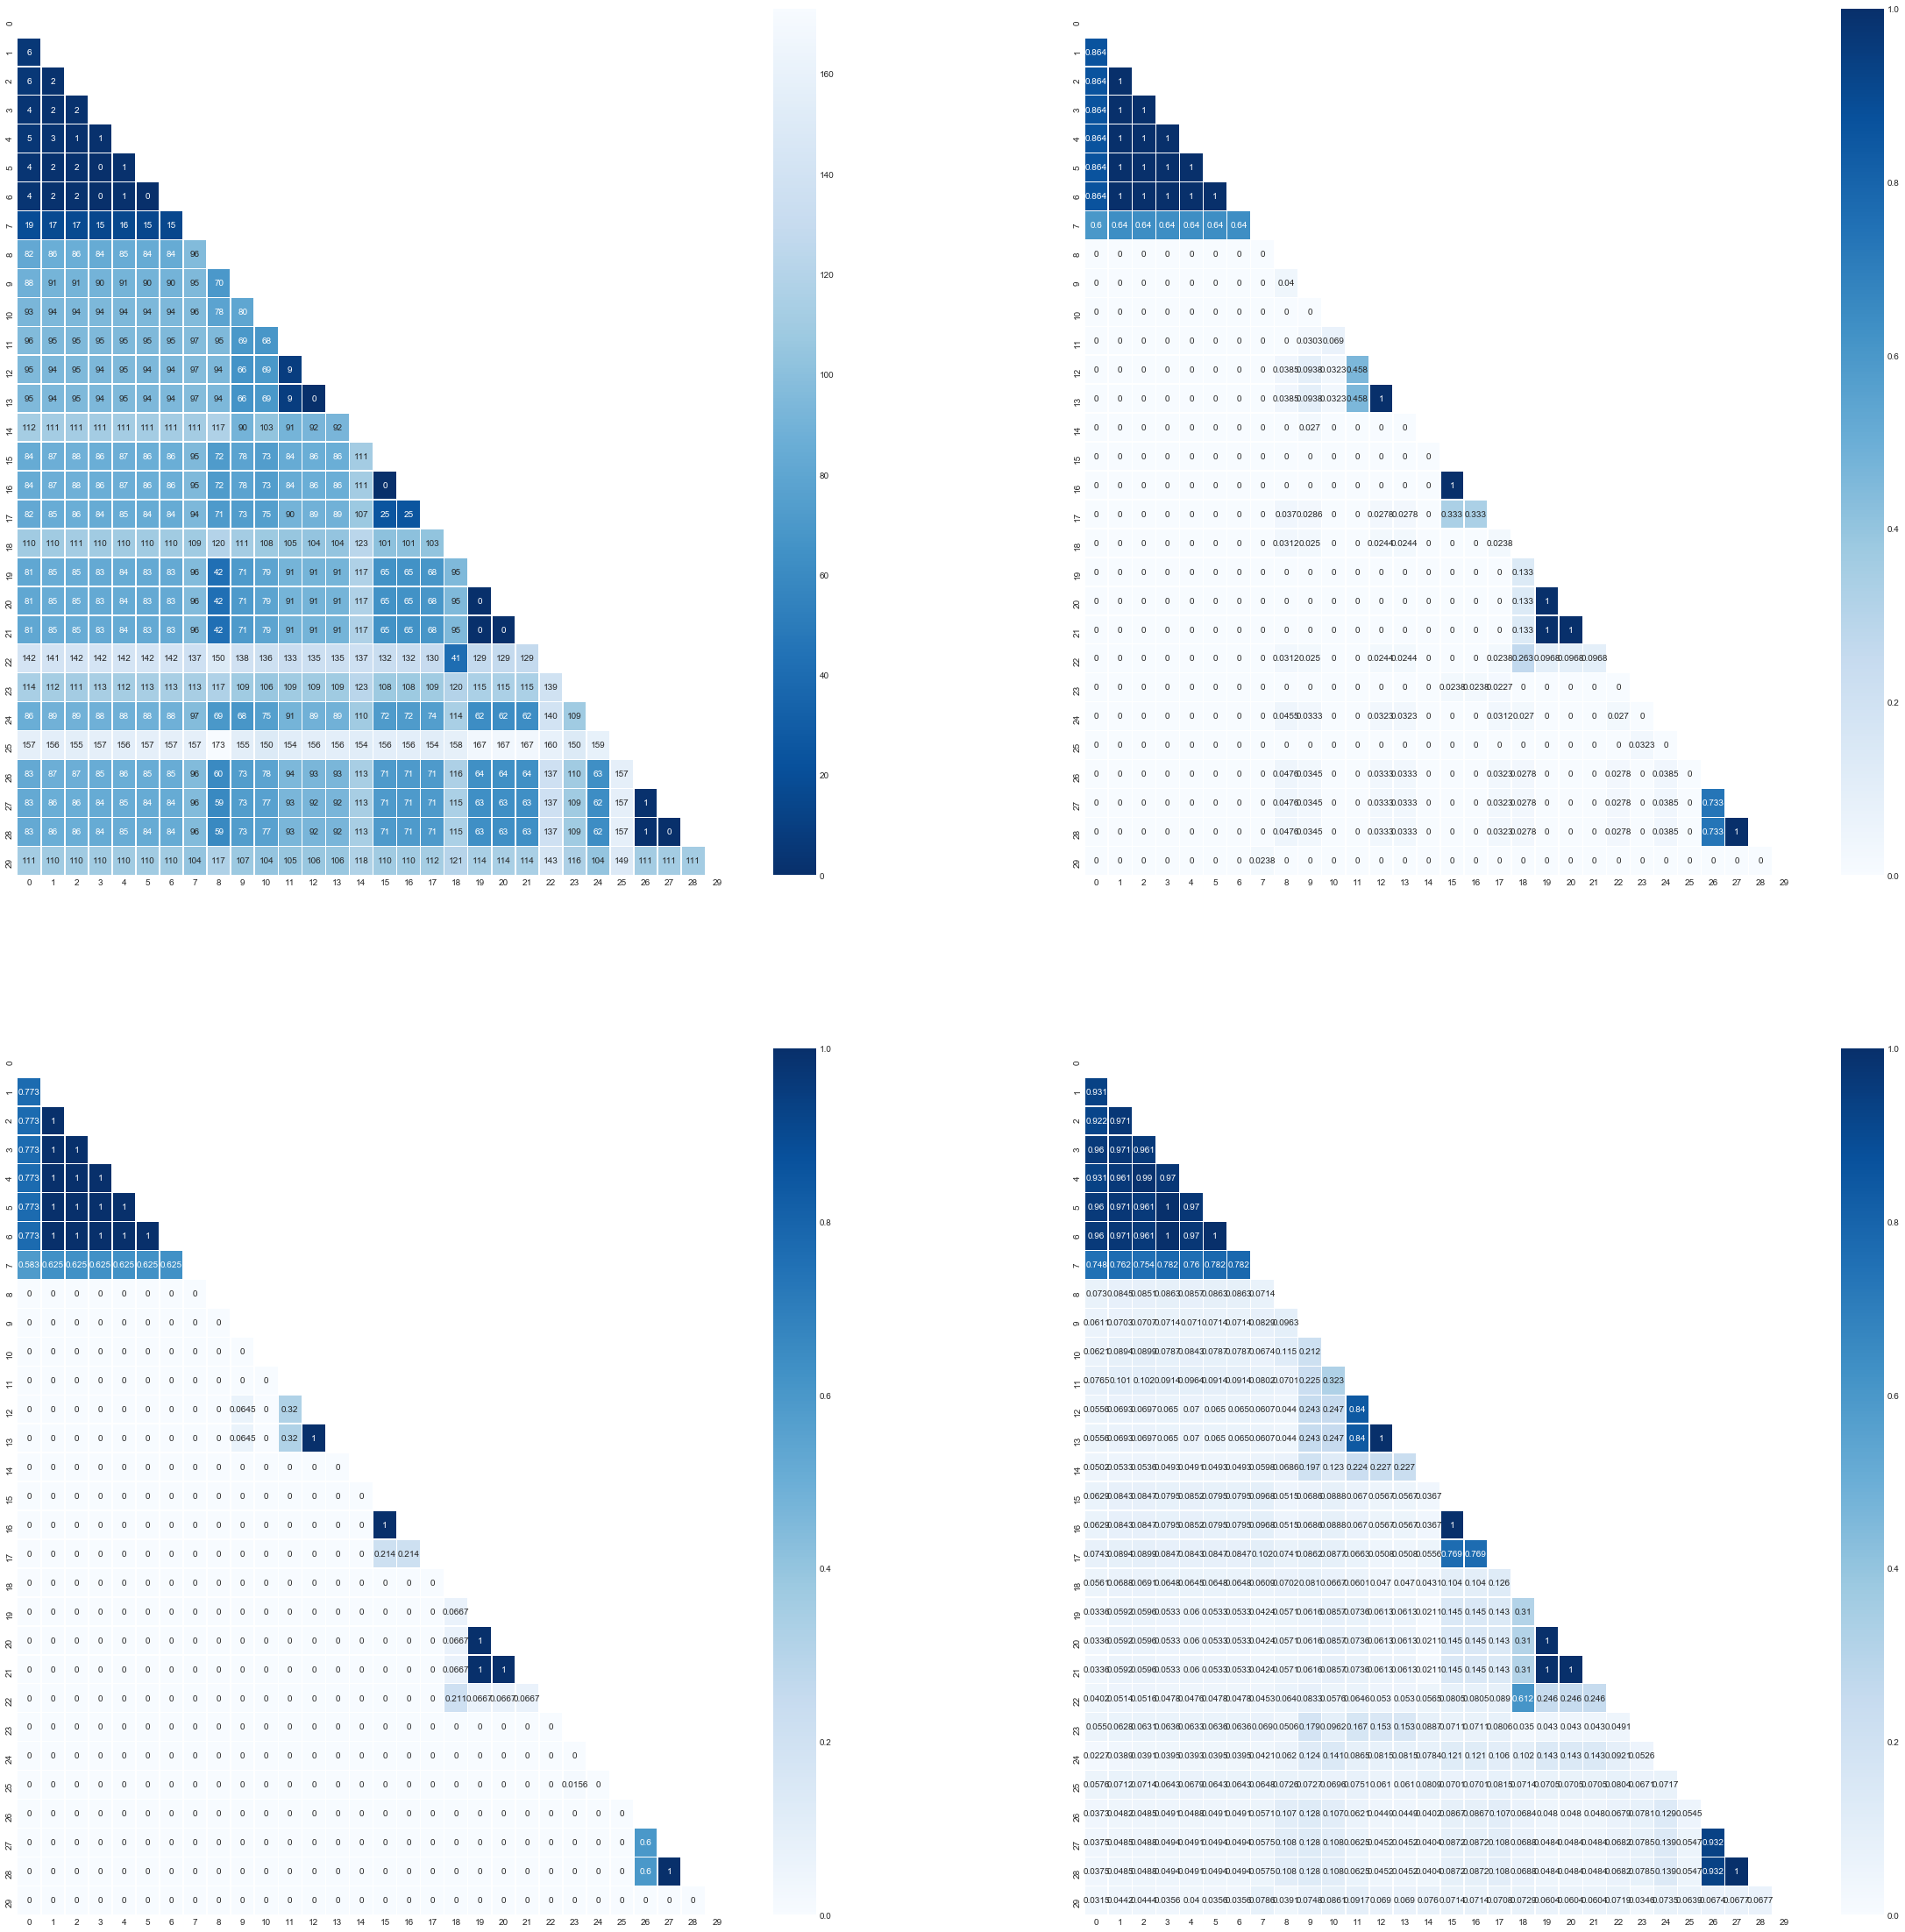

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,40))
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(ed_matrix,  annot=True, linewidths=.5,cmap="Blues_r",fmt='.3g',mask=mask, ax=ax1)
sns.heatmap(js2_matrix, annot=True, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax2)
sns.heatmap(js3_matrix, annot=True, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax3)
sns.heatmap(jc3_matrix, annot=True, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax4)

In [73]:
mat=[[1, 2, 3],[1, 2, 3],[1, 2, 3]]
mat = np.array(mat)
print(mat)
# corr = np.corrcoef(mat)
# mask = np.zeros_like(corr)
print(np.triu_indices(mat))

[[1 2 3]
 [1 2 3]
 [1 2 3]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Edit Distance Heatmap

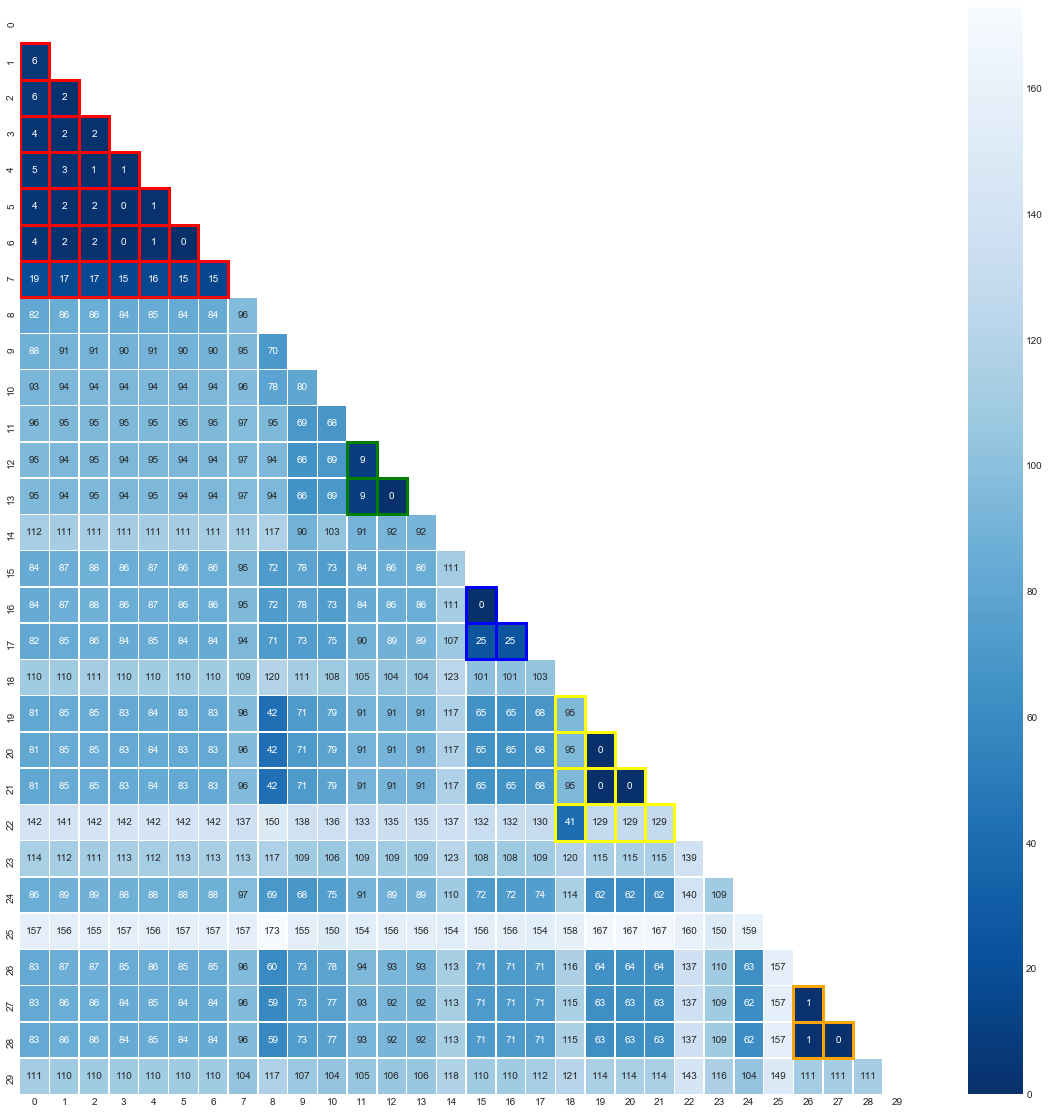

In [40]:
fif,ax = plt.subplots(1,figsize=(20,20))
colors = ['red','green','blue','yellow','orange']
c=0
for cl in clusters:
    for i  in range(0,len(cl)):
        for j in range(i+1,len(cl)):
            ax.add_patch(Rectangle(( cl[i],cl[j]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
    c+=1
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(ed_matrix, linewidth=0.5,annot=True,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
# plt.legend(legendclusters,colors)
# print(legendclusters)
plt.show()

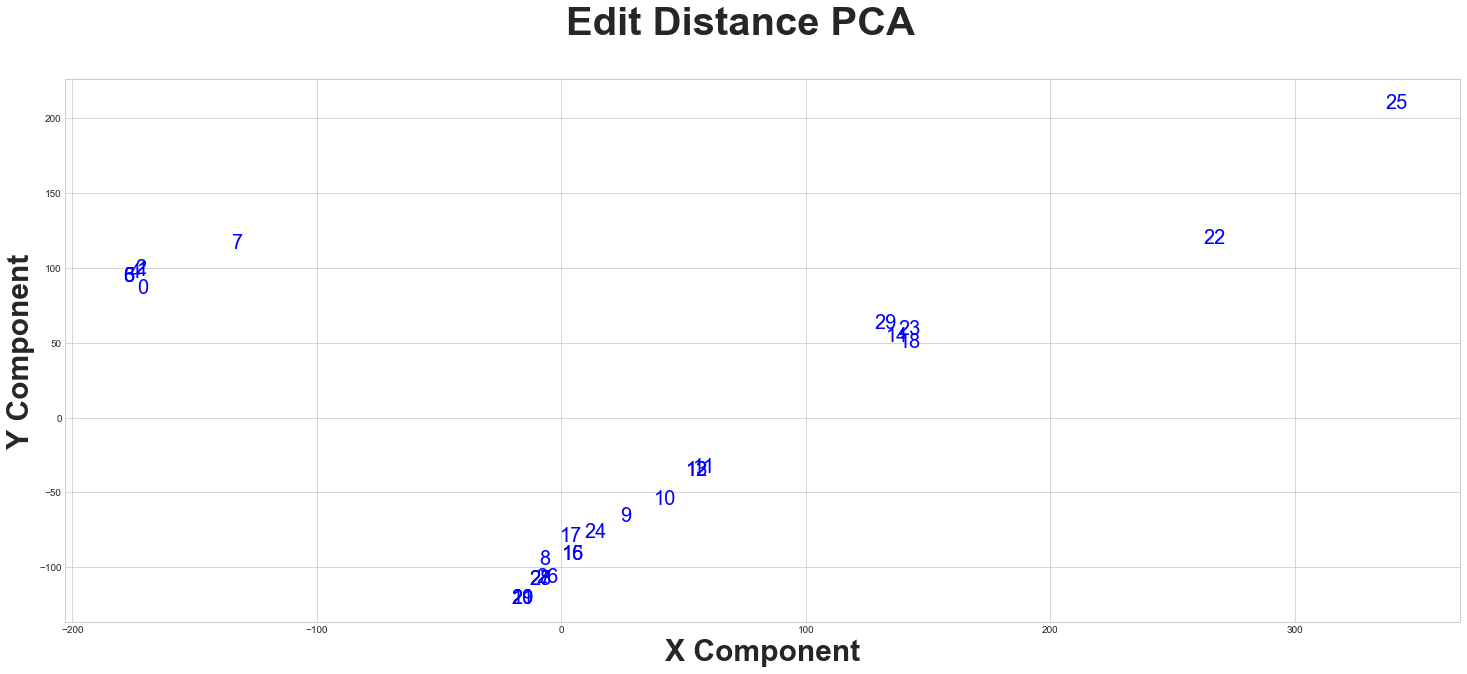

In [21]:
pcaComponents = PCA_SpaceVisualization(ed_matrix, 'Edit Distance PCA')

### Jaccard distance - using bgramms (2,3) Heatmap

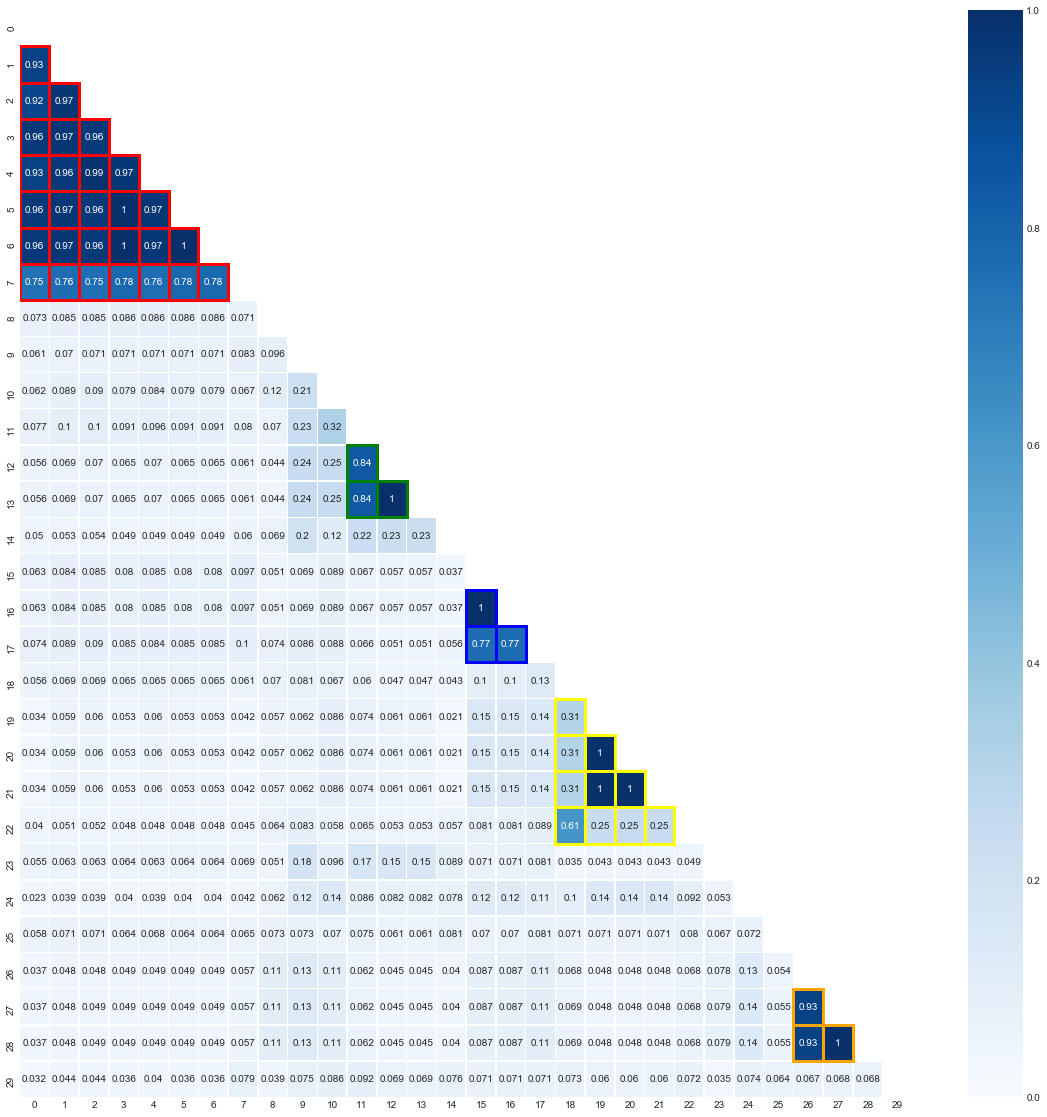

In [22]:
fif,ax = plt.subplots(1,figsize=(20,20))
colors = ['red','green','blue','yellow','orange']
c=0
for cl in clusters:
    for i  in range(0,len(cl)):
        for j in range(i+1,len(cl)):
            ax.add_patch(Rectangle((cl[i],cl[j]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
    c+=1
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(jc3_matrix, linewidth=0.5,annot=True,cmap="Blues",mask=mask,fmt='.2g',ax=ax)
plt.show()

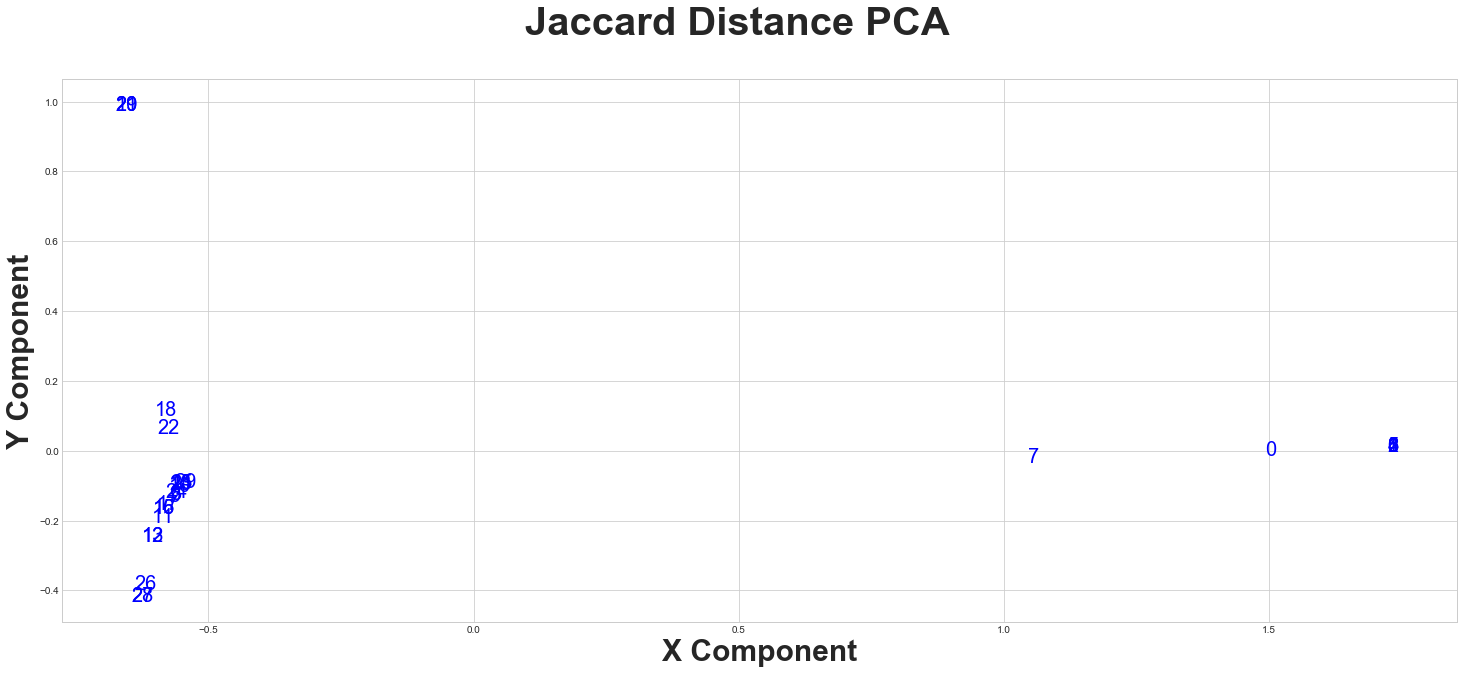

In [23]:
pcaComponents = PCA_SpaceVisualization(js2_matrix,  'Jaccard Distance PCA')

### Evaluation

In [24]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3  9 13 17 21 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  6

# Finished in 0.0194 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 5 6 3 2 4]
 [1 4 5 2 2 3]
 [1 4 5 3 2 3]
 [1 4 5 3 2 3]
 [1 4 5 3 2 3]
 [1 4 5 3 2 3]
 [1 4 5 3 2 3]
 [1 3 5 2 4 4]
 [5 3 6 4 1 2]
 [5 1 2 4 3 4]
 [6 5 1 2 4 3]
 [6 2 1 3 4 5]
 [6 2 1 3 4 5]
 [6 2 1 3 4 5]
 [4 1 2 3 6 5]
 [5 4 5 1 2 3]
 [5 4 5 1 2 3]
 [5 4 6 1 2 3]
 [4 5 3 2 1 6]
 [5 4 6 3 1 2]
 [5 4 6 3 1 2]
 [5 4 6 3 1 2]
 [6 5 3 2 1 4]
 [2 1 1 1 3 1]
 [4 2 5 3 1 1]
 [4 2 3 1 5 4]
 [5 4 6 3 2 1]
 [5 4 6 3 2 1]
 [5 4 6 3 2 1]
 [3 2 1 5 6 4]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3 2 5 2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 8, 17, 19, 20, 21, 24, 26, 27, 28]
[1 3 0 3]  ->  [9, 10, 11, 12, 13, 22]
[5 1 3 1]  ->  [14, 23, 25, 29]
[1 2 0 2]  ->  [15, 16]
[2 0 1 0]  ->  [18]

- WTA number of buckets:  5

- WTA RankedVectors after permutation:
[[4 2 6 1 3 5]
 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 17, 19, 20, 21, 24, 26, 27, 28]
[9, 10, 11, 12, 13, 22]
[14, 23, 25, 29]
[15, 16]
[18]

- Similarity matrix (all values compared):
[[        nan  0.96609178  0.96609178  0.96609178  0.96609178  0.96609178
   0.96609178  0.55205245  0.2                nan         nan         nan
          nan         nan         nan         nan         nan  0.33333333
          nan  0.33333333  0.33333333  0.33333333         nan         nan
   0.13801311         nan  0.2         0.2         0.2                nan]
 [        nan         nan  0.92857143  0.92857143  0.92857143  0.92857143
   0.92857143  0.64285714  0.13801311         nan         nan         nan
          nan         nan         nan         nan         nan  0.41403934
          nan  0.27602622  0.27602622  0.27602622         nan         nan
   0.07142857         nan  0.13801311  0.13801311  0.13801311         nan]
 [        nan         nan         nan  1.          1.          1.
   1.          0.5         0.2760

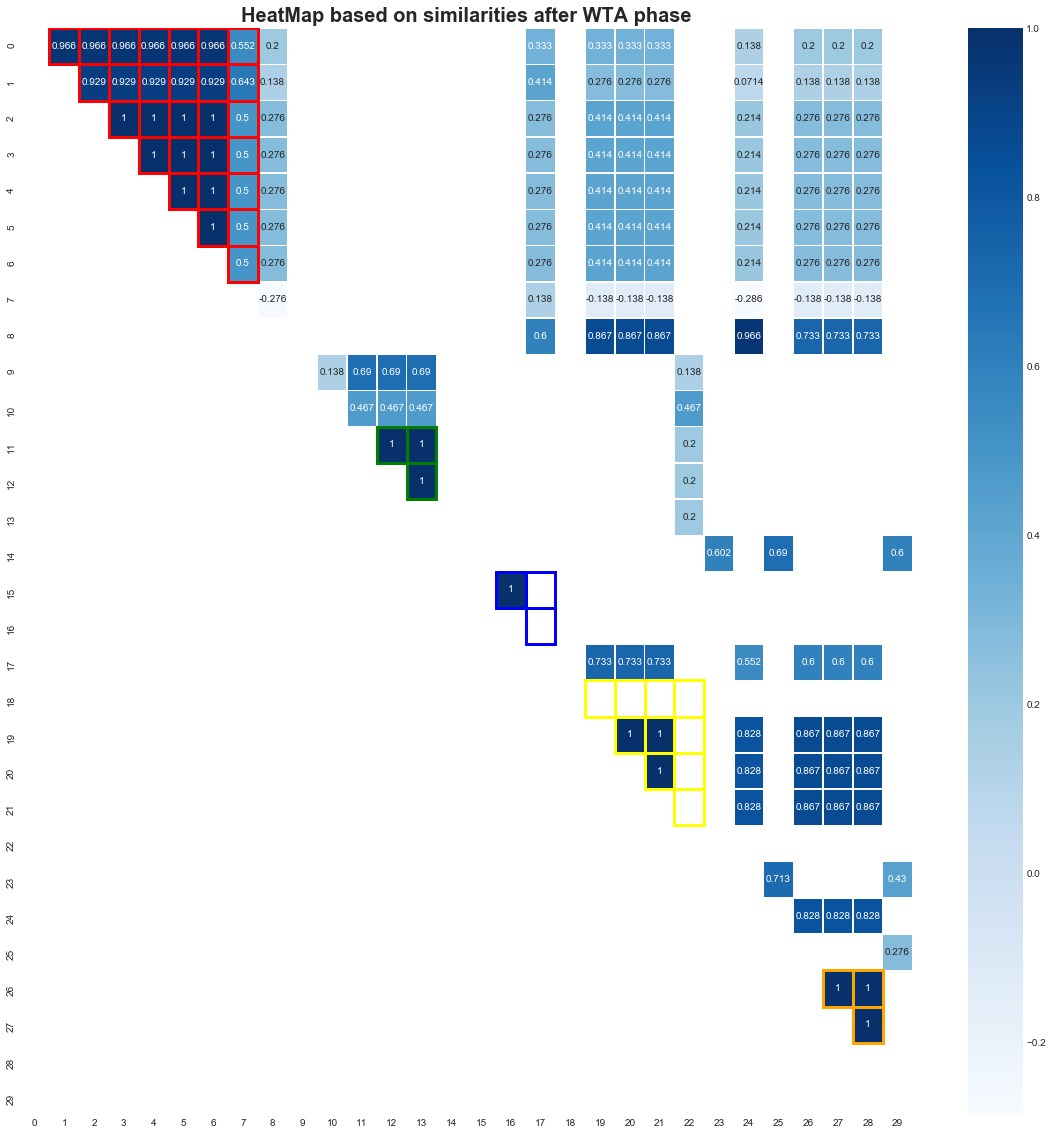

Wall time: 1.04 s


In [65]:
%%time
model = RankedWTAHash(
    max_numberOf_clusters= 20,
    max_editDistance= 100,
    windowSize= 6,
    similarityThreshold= 0.7,
    metric='kendal',
    similarityVectors='ranked',
    number_of_permutations = 4,
    distanceMetric= 'edit',
    distanceMetricEmbedding = 'edit',
    ngramms= 3
)
model = model.fit(data)
evaluate_cora(model.mapping_matrix,true_matrix, True)
similarityProbsHeatMap(model.similarityProb_matrix,clusters,'HeatMap based on similarities after WTA phase')

## Inspecting performance

### Embeddings

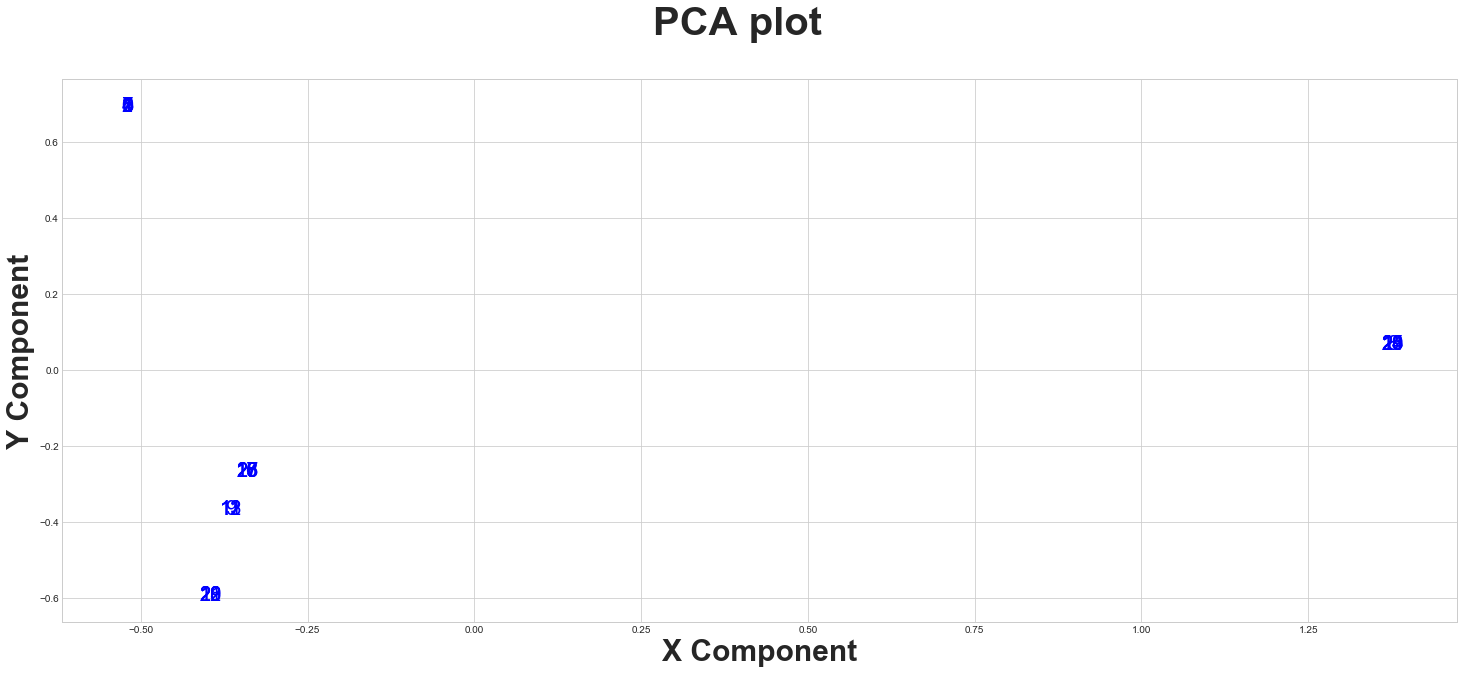

In [43]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

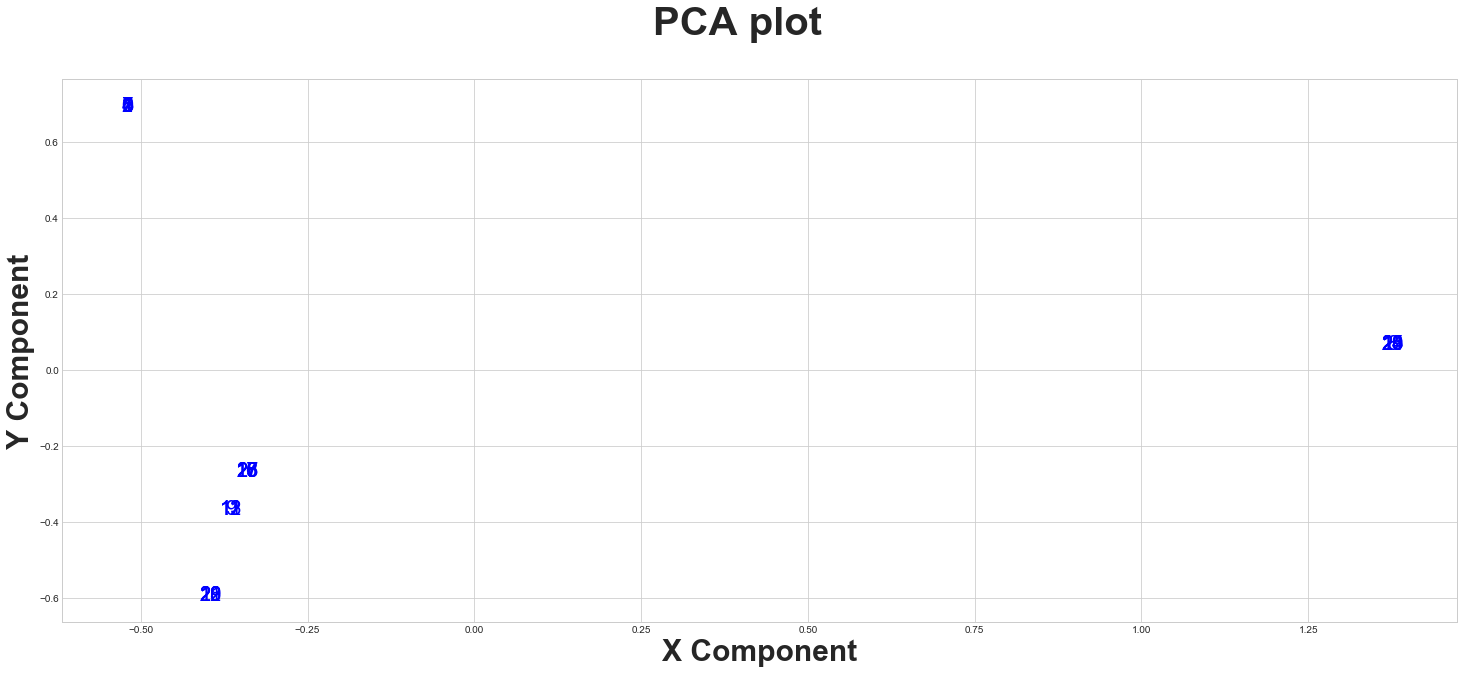

In [44]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

### Bucket similarity

In [49]:
max_numberOf_clusters= [10,20, 50, 100]
max_editDistance= [200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.8,0.9]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']

results_shuffled = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors)

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6]
[1]  ->  [7, 14, 23, 25, 29]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 2 1]
 [2 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [2 3 1]
 [4 1 5]
 [3 2 4]
 [1 3 4]
 [1 2 4]
 [1 2 4]
 [1 2 4]


[0, 1, 2, 3, 4, 5, 6]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6]
[2]  ->  [7, 14, 23, 25, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 3 2]
 [1 2 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 2 3]
 [5 4 1]
 [4 3 2]
 [4 1 3]
 [4 1 2]
 [4 1 2]
 [4 1 2]


[0, 1, 2, 3, 4, 5, 6]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[0]  ->  [9, 11, 12, 13, 18, 19, 20, 21, 24]
[1]  ->  [10, 14, 23, 25, 26, 27, 28, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 2 5]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 3 4]
 [2 1 3]
 [3 2 1]
 [2 3 1]
 [3 2 2]
 [3 2 1]
 [3 2 1]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[9, 11, 12, 13, 18, 19, 20, 21, 24]
[10, 14, 23, 25, 26, 27, 28, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[2]  ->  [9, 11, 12, 13, 18, 19, 20, 21]
[1]  ->  [10, 14, 23, 24, 25, 26, 27, 28, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 2 4]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 3 3]
 [3 1 2]
 [1 2 3]
 [1 3 2]
 [2 2 3]
 [1 2 3]
 [1 2 3]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[9, 11, 12, 13, 18, 19, 20, 21]
[10, 14, 23, 24, 25, 26, 27, 28, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6]
[2]  ->  [7, 14, 23, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 1 2]
 [2 1 2]
 [3 1 2]
 [3 1 2]
 [3 1 2]
 [3 1 2]
 [3 1 2]
 [2 1 3]
 [4 5 1]
 [3 4 2]
 [1 4 3]
 [1 4 2]
 [1 4 2]
 [1 4 2]


[0, 1, 2, 3, 4, 5, 6]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0230 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0343 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 3 1]
 [2 1 5]
 [3 2 4]
 [2 3 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[2]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[1]  ->  [10, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 2 3]
 [4 2 2]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 3 2]
 [3 1 4]
 [1 2 3]
 [1 3 1]
 [2 2 1]
 [1 2 1]
 [1 2 1]


[0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6]
[1]  ->  [7, 14, 23, 25, 29]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 2 1]
 [2 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [2 3 1]
 [4 1 5]
 [3 2 4]
 [1 3 4]
 [1 2 4]
 [1 2 4]
 [1 2 4]


[0, 1, 2, 3, 4, 5, 6]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0479 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 4 3 5]
 [1 2 3 2 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 3 3 2 4]
 [5 1 2 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 3 2 4]
 [4 1 2 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 2 3 3]
 [3 5 4 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 1 4 5]
 [2 2 1 3 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [3 2 1 3 4]
 [1 4 5 2 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0264 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0830 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 1 3 5 4]
 [2 1 2 4 3]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [3 1 2 4 3]
 [1 5 4 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 4 2 5]
 [2 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [2 1 3 3 4]
 [4 5 2 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0246 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0385 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 5 2 4]
 [2 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [2 1 4 3 3]
 [4 5 3 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0709 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0449 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 4 1 3]
 [2 4 3 1 2]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [3 4 3 1 2]
 [1 3 2 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0335 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 2 1 3 5]
 [3 2 1 2 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 3 1 2 4]
 [2 1 5 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 3 5 4]
 [1 2 2 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 2 4 3]
 [5 1 4 3 2]

C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:450: UserWarning: Window size greater than vector dimension


[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 5 1 2]
 [3 2 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 2 4 1 3]
 [2 4 3 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0335 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0415 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 3 5 1]
 [2 3 2 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [3 3 2 4 1]
 [1 2 4 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 4 2 5]
 [2 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [2 1 3 3 4]
 [4 5 2 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 2 4 1 3]
 [4 2 3 1 2]
 [4 2 3 1 3]
 [4 2 3 1 3]
 [4 2 3 1 3]
 [4 2 3 1 3]
 [4 2 3 1 3]
 [4 3 3 1 2]
 [3 1 2 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0329 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 5 4 1]
 [2 2 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [3 2 4 3 1]
 [1 4 3 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 1 5 3]
 [2 3 1 4 2]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [3 3 1 4 2]
 [1 2 5 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 2 4 3]
 [4 1 2 3 2]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 3 3 2]
 [3 5 1 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 2 5 1]
 [3 2 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 2 3 4 1]
 [2 4 1 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 3 2 1]
 [3 4 2 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 2 3 1]
 [2 3 4 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 4 2 1]
 [4 2 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 2 3 3 1]
 [3 4 2 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 2 1 3]
 [3 4 2 1 2]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 3 1 2]
 [2 3 1 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 1 2 5]
 [3 2 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [3 2 1 3 4]
 [2 4 5 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 4 1 2]
 [2 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [2 4 3 1 3]
 [4 3 2 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 2 3 5]
 [1 3 2 2 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 3 3 2 4]
 [5 2 1 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0485 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 4 2 3]
 [4 1 3 2 2]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 3 2]
 [3 5 2 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0315 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[2]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[1]  ->  [10, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 2 3]
 [4 2 2]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 3 2]
 [3 1 4]
 [1 2 3]
 [1 3 1]
 [2 2 1]
 [1 2 1]
 [1 2 1]


[0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0295 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 3 1]
 [3 2 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 2 1]
 [2 4 5]
 [3 3 4]
 [2 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]


[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0329 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 3 1]
 [4 2 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 2 1]
 [3 4 5]
 [1 3 4]
 [1 1 4]
 [2 1 4]
 [1 1 4]
 [1 1 4]


[0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0404 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 3 1]
 [2 1 5]
 [3 2 4]
 [2 3 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0305 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0395 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 11, 12, 13, 15, 16, 17, 18, 22]
[1]  ->  [2, 3, 4, 5, 6, 8, 9, 19, 20, 21, 24, 26, 27, 28]
[0]  ->  [7, 10, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 3 4]
 [2 2 3]
 [2 3 3]
 [2 3 3]
 [2 3 3]
 [2 3 3]
 [2 3 3]
 [3 2 3]
 [1 4 2]
 [2 3 3]
 [3 1 2]
 [2 1 3]
 [2 1 3]
 [2 1 3]


[0, 1, 11, 12, 13, 15, 16, 17, 18, 22]
[2, 3, 4, 5, 6, 8, 9, 19, 20, 21, 24, 26, 27, 28]
[7, 10, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[2]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[0]  ->  [10, 11, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 5 3]
 [2 4 2]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [3 4 2]
 [1 3 4]
 [2 1 3]
 [3 1 1]
 [2 2 1]
 [2 1 1]
 [2 1 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 11, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 23, 25]
[1]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28, 29]
[2]  ->  [10, 11, 12, 13, 14, 18]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 3 4]
 [4 2 3]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 2 3]
 [3 4 2]
 [1 3 3]
 [1 1 2]
 [2 1 3]
 [1 1 3]
 [1 1 3]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 23, 25]
[8, 9, 19, 20, 21, 24, 26, 27, 28, 29]
[10, 11, 12, 13, 14, 18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

C:\Users\nikol\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[2]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 4 3]
 [1 3 2]
 [1 3 3]
 [1 3 3]
 [1 3 3]
 [1 3 3]
 [1 3 3]
 [1 3 2]
 [5 2 4]
 [4 3 3]
 [4 2 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]


[0, 1, 2, 3, 4, 5, 6, 7, 14, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 5 1 2]
 [3 2 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 2 4 1 3]
 [2 4 3 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 1 5 4 3]
 [2 1 4 3 2]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [3 1 4 3 2]
 [1 5 3 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 3 5 1]
 [2 3 2 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [3 3 2 4 1]
 [1 2 4 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0399 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 3 5 1]
 [2 3 2 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [3 3 2 4 1]
 [1 2 4 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0429 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 1 4 3 5]
 [2 1 3 2 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [3 1 3 2 4]
 [1 5 2 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0409 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 5 4 3]
 [1 2 4 3 2]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 3 4 3 2]
 [5 1 3 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0450 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 1 4 5 3]
 [2 1 3 4 2]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [2 1 3 4 3]
 [3 1 3 4 2]
 [1 5 2 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0340 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0560 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 1 3 2]
 [4 3 1 2 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 2 3]
 [3 2 5 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0429 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 2 5 3]
 [1 3 2 4 2]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 3 4 2]
 [5 2 1 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 1 2 4]
 [4 2 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 2 1 3 3]
 [3 4 5 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 5 2 4]
 [1 2 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 2 4 3 3]
 [5 4 3 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 1 3 2]
 [4 3 1 2 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 2 3]
 [3 2 5 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0329 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 2 3 1]
 [4 3 2 2 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 3 2 1]
 [3 2 1 4 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 1 2 3]
 [4 3 1 2 2]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 3 2]
 [3 2 5 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0230 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 4 5 2]
 [2 1 3 4 2]
 [3 1 3 4 2]
 [3 1 3 4 2]
 [3 1 3 4 2]
 [3 1 3 4 2]
 [3 1 3 4 2]
 [2 1 3 4 3]
 [4 5 2 3 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 5 4 2]
 [2 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [2 1 4 3 3]
 [4 5 3 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 1 3 2]
 [3 4 1 2 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 2 3]
 [2 3 5 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 4 5 3]
 [1 2 3 4 2]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 3 4 2]
 [5 1 2 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 2 5 4 1]
 [2 2 4 3 1]
 [3 2 4 3 1]
 [3 2 4 3 1]
 [3 2 4 3 1]
 [3 2 4 3 1]
 [3 2 4 3 1]
 [2 3 4 3 1]
 [4 1 3 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 1 2 3]
 [4 3 1 2 2]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 3 2]
 [3 2 5 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0399 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 1 3 2]
 [4 3 1 2 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 2 3]
 [3 2 5 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 2 1 5 3]
 [3 2 1 4 2]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [3 3 1 4 2]
 [2 1 5 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 3 2 4]
 [4 1 2 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 2 3 3]
 [3 5 4 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0459 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 5 3 2]
 [3 1 4 2 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 2 3]
 [2 5 3 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0390 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0409 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0220 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0410 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0420 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0409 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0385 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0035 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0315 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0440 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0589 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0480 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0440 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0415 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0069 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0479 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0479 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0060 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0379 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0080 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0639 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0649 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0450 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0409 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0060 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0296 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0405 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0269 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0597 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0379 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0490 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0115 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0475 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0329 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0415 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0359 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0440 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0399 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0450 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0399 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0060 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0479 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0440 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0449 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0500 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0490 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0490 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0419 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0450 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0469 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0440 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0470 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0419 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0429 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0079 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0480 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0399 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0450 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0490 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0520 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0509 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0059 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0365 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0480 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0449 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0449 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0599 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0080 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0519 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 3 1]
 [3 2 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 2 1]
 [2 4 5]
 [3 3 4]
 [2 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]


[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0450 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 25]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[0]  ->  [14, 18, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 1 5]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [2 5 3]
 [3 4 1]
 [2 4 1]
 [3 4 2]
 [3 4 1]
 [3 4 1]


[0, 1, 2, 3, 4, 5, 6, 7, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[14, 18, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0359 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0510 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[0]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[1]  ->  [10, 11, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 2 5]
 [2 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [2 3 4]
 [4 1 3]
 [3 2 1]
 [1 3 1]
 [1 2 2]
 [1 2 1]
 [1 2 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 11, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0450 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 23, 25]
[2]  ->  [8, 19, 20, 21, 24, 26, 27, 28, 29]
[1]  ->  [9, 10, 11, 12, 13, 14, 18]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 4 3]
 [4 3 2]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 2]
 [3 2 4]
 [1 3 3]
 [1 2 1]
 [2 3 1]
 [1 3 1]
 [1 3 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 23, 25]
[8, 19, 20, 21, 24, 26, 27, 28, 29]
[9, 10, 11, 12, 13, 14, 18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 7, 14, 18, 25]
[0]  ->  [2, 3, 4, 5, 6, 29]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 4 1]
 [2 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [2 3 1]
 [4 2 5]
 [3 3 4]
 [1 2 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]


[0, 1, 7, 14, 18, 25]
[2, 3, 4, 5, 6, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 2, 3, 4, 5, 6]
[1]  ->  [1, 7, 14, 23, 25, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 2 3]
 [1 2 2]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 3 2]
 [5 1 4]
 [4 2 3]
 [4 3 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]


[0, 2, 3, 4, 5, 6]
[1, 7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 11, 12, 13, 15, 16, 17, 18, 22]
[0]  ->  [2, 3, 4, 5, 6, 8, 9, 19, 20, 21, 24, 26, 27, 28]
[1]  ->  [7, 10, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 2 4]
 [2 2 3]
 [3 2 3]
 [3 2 3]
 [3 2 3]
 [3 2 3]
 [3 2 3]
 [2 3 3]
 [4 1 2]
 [3 2 3]
 [1 3 2]
 [1 2 3]
 [1 2 3]
 [1 2 3]


[0, 1, 11, 12, 13, 15, 16, 17, 18, 22]
[2, 3, 4, 5, 6, 8, 9, 19, 20, 21, 24, 26, 27, 28]
[7, 10, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 4 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 3]
 [5 2 1]
 [4 3 2]
 [4 2 3]
 [4 3 2]
 [4 3 2]
 [4 3 2]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 2 3 5 1]
 [3 2 2 4 1]
 [3 2 3 4 1]
 [3 2 3 4 1]
 [3 2 3 4 1]
 [3 2 3 4 1]
 [3 2 3 4 1]
 [3 3 2 4 1]
 [2 1 4 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0560 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 4 3 5]
 [1 2 3 2 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 3 3 2 4]
 [5 1 2 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 3 2 1]
 [4 3 2 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 2 3 1]
 [3 2 4 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 5 2 3]
 [3 1 4 2 2]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 3 2]
 [2 5 3 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 3 2 4]
 [4 1 2 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 2 3 3]
 [3 5 4 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 1 2 4]
 [2 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [2 4 1 3 3]
 [4 3 5 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 2 1 5]
 [3 2 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 2 3 1 4]
 [2 4 1 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 3 1 4]
 [2 4 2 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [3 4 2 1 3]
 [1 3 4 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0282 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 2 3 4]
 [4 1 2 2 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 3 2 3]
 [3 5 1 4 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 5 4 1]
 [2 2 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [3 2 4 3 1]
 [1 4 3 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0337 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0530 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 3 1 4]
 [2 4 2 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [3 4 2 1 3]
 [1 3 4 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 4 1 2]
 [2 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [2 4 3 1 3]
 [4 3 2 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 3 2 4]
 [1 4 2 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 2 3 3]
 [5 3 4 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0410 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 5 1 4]
 [2 2 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [3 2 4 1 3]
 [1 4 3 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 2 1 5 4]
 [2 2 1 4 3]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [3 2 1 4 3]
 [2 3 1 4 3]
 [4 1 5 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 2 3 1]
 [4 3 2 2 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 3 2 1]
 [3 2 1 4 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0239 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 1 4 2]
 [4 2 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 2 1 3 3]
 [3 4 5 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 1 2 4]
 [4 2 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 2 1 3 3]
 [3 4 5 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 2 3 1]
 [3 4 2 2 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 3 2 1]
 [2 3 1 4 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 4 5 3]
 [1 2 3 4 2]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 3 4 2]
 [5 1 2 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0600 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 3 4 5]
 [1 2 2 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 2 3 3 4]
 [1 3 2 3 4]
 [5 1 4 2 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 1 4 3]
 [2 4 1 3 2]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [3 4 1 3 2]
 [1 3 5 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0430 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 3 4 2]
 [1 4 2 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 2 3 3]
 [5 3 4 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[2]  ->  [9, 11, 12, 13, 18, 19, 20, 21]
[1]  ->  [10, 14, 23, 24, 25, 26, 27, 28, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 2 4]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 3 3]
 [3 1 2]
 [1 2 3]
 [1 3 2]
 [2 2 3]
 [1 2 3]
 [1 2 3]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[9, 11, 12, 13, 18, 19, 20, 21]
[10, 14, 23, 24, 25, 26, 27, 28, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 2, 3, 4, 5, 6]
[1]  ->  [1, 7, 14, 23, 25, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 2 3]
 [1 2 2]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 3 2]
 [5 1 4]
 [4 2 3]
 [4 3 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]


[0, 2, 3, 4, 5, 6]
[1, 7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[0]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[1]  ->  [10, 11, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 2 5]
 [2 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [3 2 4]
 [2 3 4]
 [4 1 3]
 [3 2 1]
 [1 3 1]
 [1 2 2]
 [1 2 1]
 [1 2 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 11, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 25]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [14, 18, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 4 5]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [5 2 3]
 [4 3 1]
 [4 2 1]
 [4 3 2]
 [4 3 1]
 [4 3 1]


[0, 1, 2, 3, 4, 5, 6, 7, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[14, 18, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6]
[2]  ->  [7, 14, 23, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 1 2]
 [2 1 2]
 [3 1 2]
 [3 1 2]
 [3 1 2]
 [3 1 2]
 [3 1 2]
 [2 1 3]
 [4 5 1]
 [3 4 2]
 [1 4 3]
 [1 4 2]
 [1 4 2]
 [1 4 2]


[0, 1, 2, 3, 4, 5, 6]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 7, 14, 18, 25]
[0]  ->  [2, 3, 4, 5, 6, 29]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 4 1]
 [2 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [2 3 1]
 [4 2 5]
 [3 3 4]
 [1 2 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]


[0, 1, 7, 14, 18, 25]
[2, 3, 4, 5, 6, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [14, 18, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 4 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [3 2 5]
 [1 3 4]
 [1 2 4]
 [2 3 4]
 [1 3 4]
 [1 3 4]


[0, 1, 2, 3, 4, 5, 6, 7, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[14, 18, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0230 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 1 5]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [3 1 4]
 [1 5 3]
 [2 4 1]
 [3 4 1]
 [2 4 2]
 [2 4 1]
 [2 4 1]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 2 5 1]
 [2 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [2 3 3 4 1]
 [4 2 1 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 4 5 2]
 [1 2 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 2 3 4 3]
 [5 4 2 3 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 3 1 2]
 [3 4 2 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 2 1 3]
 [2 3 4 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 2 4 1 5]
 [2 2 3 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [2 3 3 1 4]
 [4 1 2 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 4 1 5]
 [2 2 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [3 2 3 1 4]
 [1 4 2 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0420 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 2 5 1]
 [3 2 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 2 3 4 1]
 [2 4 1 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 4 5 2]
 [1 2 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 2 3 4 3]
 [5 4 2 3 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 4 5 3]
 [1 2 3 4 2]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 3 4 2]
 [5 1 2 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 4 2 5]
 [2 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [2 1 3 3 4]
 [4 5 2 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 3 5 2]
 [1 3 2 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 2 4 3]
 [5 2 4 3 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 3 2 1]
 [3 4 2 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 2 3 1]
 [2 3 4 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 5 4 3]
 [1 2 4 3 2]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 3 4 3 2]
 [5 1 3 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 4 2 1]
 [2 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [2 4 3 3 1]
 [4 3 2 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0430 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 2 5 3]
 [3 1 2 4 2]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 3 4 2]
 [2 5 1 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 2 3 1]
 [3 4 2 2 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 3 2 1]
 [2 3 1 4 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 2 3 1 5]
 [3 2 2 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [3 2 3 1 4]
 [3 3 2 1 4]
 [2 1 4 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 2 1 3]
 [4 3 2 1 2]
 [4 3 2 1 3]
 [4 3 2 1 3]
 [4 3 2 1 3]
 [4 3 2 1 3]
 [4 3 2 1 3]
 [4 3 3 1 2]
 [3 2 1 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0380 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 1 4 2]
 [4 2 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 2 1 3 3]
 [3 4 5 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 5 1 2]
 [2 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [2 3 4 1 3]
 [4 2 3 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 2 3 5]
 [3 1 2 2 4]
 [3 1 2 3 4]
 [3 1 2 3 4]
 [3 1 2 3 4]
 [3 1 2 3 4]
 [3 1 2 3 4]
 [3 1 3 2 4]
 [2 5 1 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 3 1 4]
 [2 4 2 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [3 4 2 1 3]
 [1 3 4 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 1 2 4]
 [4 2 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 3 1 2 3]
 [4 2 1 3 3]
 [3 4 5 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 2 1 3 4]
 [4 2 1 2 3]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 3 1 2 3]
 [3 1 5 4 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0283 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0360 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0280 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0280 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0280 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0300 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0280 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0300 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0270 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0346 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0529 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0510 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0360 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0060 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0395 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0419 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0395 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0449 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0510 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0339 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0430 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0425 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0449 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0619 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0505 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0485 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0410 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0450 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0069 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0405 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0530 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0449 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0340 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0409 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0429 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0470 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0629 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0375 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0485 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0450 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0420 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0399 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0379 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0645 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0615 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0060 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0560 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0539 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0520 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0059 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0429 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0565 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  20
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0440 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0490 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[2]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 4 3]
 [1 3 2]
 [1 3 3]
 [1 3 3]
 [1 3 3]
 [1 3 3]
 [1 3 3]
 [1 3 2]
 [5 2 4]
 [4 3 3]
 [4 2 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]


[0, 1, 2, 3, 4, 5, 6, 7, 14, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 15, 16, 17, 18, 22]
[0]  ->  [7, 10, 14, 23, 25, 29]
[2]  ->  [8, 19, 20, 21, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 4 3]
 [2 3 2]
 [2 3 3]
 [2 3 3]
 [2 3 3]
 [2 3 3]
 [2 3 3]
 [3 3 2]
 [1 2 4]
 [2 3 3]
 [3 2 1]
 [2 3 1]
 [2 3 1]
 [2 3 1]


[0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 15, 16, 17, 18, 22]
[7, 10, 14, 23, 25, 29]
[8, 19, 20, 21, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0560 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 7, 14, 18, 25]
[0]  ->  [2, 3, 4, 5, 6, 29]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 4 1]
 [2 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [2 3 1]
 [4 2 5]
 [3 3 4]
 [1 2 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]


[0, 1, 7, 14, 18, 25]
[2, 3, 4, 5, 6, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0559 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[2]  ->  [8, 19, 20, 21, 24, 26, 27, 28, 29]
[0]  ->  [9, 10, 11, 12, 13, 14, 18, 23]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 5 3]
 [3 4 2]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 2]
 [2 3 4]
 [3 1 3]
 [2 1 1]
 [3 2 1]
 [3 1 1]
 [3 1 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[8, 19, 20, 21, 24, 26, 27, 28, 29]
[9, 10, 11, 12, 13, 14, 18, 23]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0560 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 7, 14, 18]
[0]  ->  [2, 3, 4, 5, 6, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 1 4]
 [2 1 3]
 [3 1 3]
 [3 1 3]
 [3 1 3]
 [3 1 3]
 [3 1 3]
 [2 1 3]
 [4 5 2]
 [3 4 3]
 [1 4 2]
 [1 4 3]
 [1 4 3]
 [1 4 3]


[0, 1, 7, 14, 18]
[2, 3, 4, 5, 6, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[0]  ->  [8, 9, 19, 20, 21, 23, 24, 26, 27, 28, 29]
[1]  ->  [10, 11, 12, 13, 14, 18]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 4 5]
 [2 3 4]
 [3 3 4]
 [3 3 4]
 [3 3 4]
 [3 3 4]
 [3 3 4]
 [2 3 4]
 [4 2 3]
 [3 3 1]
 [1 2 1]
 [1 3 2]
 [1 3 1]
 [1 3 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[8, 9, 19, 20, 21, 23, 24, 26, 27, 28, 29]
[10, 11, 12, 13, 14, 18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0460 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0529 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[2]  ->  [8, 19, 20, 21, 24, 26, 27, 28, 29]
[0]  ->  [9, 10, 11, 12, 13, 14, 18, 23]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 5 3]
 [3 4 2]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 2]
 [2 3 4]
 [3 1 3]
 [2 1 1]
 [3 2 1]
 [3 1 1]
 [3 1 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[8, 19, 20, 21, 24, 26, 27, 28, 29]
[9, 10, 11, 12, 13, 14, 18, 23]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0369 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0590 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[0]  ->  [8, 9, 19, 20, 21, 23, 24, 26, 27, 28, 29]
[2]  ->  [10, 11, 12, 13, 14, 18]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 5 4]
 [2 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [2 4 3]
 [4 3 2]
 [3 1 3]
 [1 1 2]
 [1 2 3]
 [1 1 3]
 [1 1 3]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[8, 9, 19, 20, 21, 23, 24, 26, 27, 28, 29]
[10, 11, 12, 13, 14, 18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0429 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 4 5 1]
 [2 2 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [3 2 3 4 1]
 [1 4 2 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0375 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0519 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 3 1 2]
 [3 4 2 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 2 1 3]
 [2 3 4 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 1 2 3]
 [3 4 1 2 2]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 3 2]
 [2 3 5 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0469 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 4 2 1]
 [2 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [2 4 3 3 1]
 [4 3 2 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0530 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 3 5 4]
 [1 2 2 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 2 4 3]
 [5 1 4 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0329 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0550 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 5 2 1]
 [2 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [2 3 4 3 1]
 [4 2 3 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0360 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0569 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 5 1 2]
 [2 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [2 3 4 1 3]
 [4 2 3 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0559 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 1 2 5]
 [2 3 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [3 3 1 2 4]
 [2 3 1 3 4]
 [4 2 5 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0509 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0579 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 1 5 4 3]
 [2 1 4 3 2]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [2 1 4 3 3]
 [3 1 4 3 2]
 [1 5 3 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0410 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0529 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 2 3 1]
 [3 4 2 2 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 3 2 1]
 [2 3 1 4 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0450 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0639 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 3 2 4]
 [1 4 2 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 2 3 3]
 [5 3 4 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0380 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 3 4 2]
 [1 4 2 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 2 3 3]
 [5 3 4 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0379 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0480 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 5 4 2]
 [2 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [2 1 4 3 3]
 [4 5 3 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0420 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 1 2 4]
 [2 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [3 4 1 2 3]
 [2 4 1 3 3]
 [4 3 5 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 1 5 4]
 [2 2 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [3 2 1 4 3]
 [1 4 5 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 2 5 1 4]
 [2 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [2 3 4 1 3]
 [4 1 3 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0349 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 4 2 1]
 [4 2 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 3 3 2 1]
 [4 2 3 3 1]
 [3 4 2 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 2 1 5]
 [3 2 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 3 2 1 4]
 [3 2 3 1 4]
 [2 4 1 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0439 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0460 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 2 1 4]
 [2 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [2 4 3 1 3]
 [4 3 1 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0459 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 1 4 2]
 [4 2 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 2 1 3 3]
 [3 4 5 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 3 5 4]
 [1 2 2 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 2 4 3]
 [5 1 4 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 2 5 1]
 [2 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [2 3 3 4 1]
 [4 2 1 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 5 2 1]
 [3 2 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 2 4 3 1]
 [2 4 3 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 5 2 3]
 [3 1 4 2 2]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 2 3]
 [3 1 4 3 2]
 [2 5 3 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0349 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[2]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[0]  ->  [10, 11, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 5 3]
 [2 4 2]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [3 4 2]
 [1 3 4]
 [2 1 3]
 [3 1 1]
 [2 2 1]
 [2 1 1]
 [2 1 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 11, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[1]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[2]  ->  [10, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 3 2]
 [4 2 2]
 [4 3 2]
 [4 3 2]
 [4 3 2]
 [4 3 2]
 [4 3 2]
 [4 2 3]
 [3 4 1]
 [1 3 2]
 [1 1 3]
 [2 1 2]
 [1 1 2]
 [1 1 2]


[0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 18]
[1]  ->  [7, 14, 23, 25, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 2 4]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 3 3]
 [5 1 2]
 [4 2 3]
 [4 3 2]
 [4 2 3]
 [4 2 3]
 [4 2 3]


[0, 1, 2, 3, 4, 5, 6, 18]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [14, 18, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 4 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [3 2 5]
 [1 3 4]
 [1 2 4]
 [2 3 4]
 [1 3 4]
 [1 3 4]


[0, 1, 2, 3, 4, 5, 6, 7, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[14, 18, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 3 1]
 [3 2 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 2 1]
 [2 4 5]
 [3 3 4]
 [2 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]


[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0429 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0600 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 3 1]
 [3 2 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 3 1]
 [3 2 1]
 [2 4 5]
 [3 3 4]
 [2 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]


[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0460 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[0]  ->  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 3 5]
 [1 2 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [1 3 4]
 [1 2 4]
 [5 4 3]
 [4 3 1]
 [4 1 1]
 [4 1 2]
 [4 1 1]
 [4 1 1]


[0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 3 1]
 [3 1 5]
 [1 2 4]
 [1 3 4]
 [2 2 4]
 [1 2 4]
 [1 2 4]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 2 5 1]
 [2 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [2 3 3 4 1]
 [4 2 1 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0500 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 2 5 1 3]
 [3 2 4 1 2]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 3 4 1 2]
 [2 1 3 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 4 3 2]
 [4 1 3 2 2]
 [4 1 3 3 2]
 [4 1 3 3 2]
 [4 1 3 3 2]
 [4 1 3 3 2]
 [4 1 3 3 2]
 [4 1 3 2 3]
 [3 5 2 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0230 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0430 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 4 5 3]
 [1 2 3 4 2]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 3 4 2]
 [5 1 2 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 2 5 3]
 [1 3 2 4 2]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 3 4 2]
 [5 2 1 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 3 5 1]
 [2 3 2 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [2 3 3 4 1]
 [3 3 2 4 1]
 [1 2 4 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 2 1 3 5]
 [3 2 1 2 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 2 1 3 4]
 [3 3 1 2 4]
 [2 1 5 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0399 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 1 5 4]
 [2 2 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [3 2 1 4 3]
 [1 4 5 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0385 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 5 4 1]
 [2 2 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [2 3 4 3 1]
 [3 2 4 3 1]
 [1 4 3 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 2 3 1]
 [4 3 2 2 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 3 2 1]
 [3 2 1 4 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 1 3 4]
 [2 4 1 2 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [3 4 1 2 3]
 [1 3 5 4 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 3 1 5]
 [2 3 2 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [3 3 2 1 4]
 [1 2 4 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 2 5 3]
 [3 1 2 4 2]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 2 4 3]
 [3 1 3 4 2]
 [2 5 1 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 3 2 5]
 [1 3 2 2 4]
 [1 3 3 2 4]
 [1 3 3 2 4]
 [1 3 3 2 4]
 [1 3 3 2 4]
 [1 3 3 2 4]
 [1 3 2 3 4]
 [5 2 4 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0349 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 5 3 4]
 [1 2 4 2 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 3 4 2 3]
 [5 1 3 4 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 2 4 3 1]
 [4 2 3 2 1]
 [4 2 3 3 1]
 [4 2 3 3 1]
 [4 2 3 3 1]
 [4 2 3 3 1]
 [4 2 3 3 1]
 [4 3 3 2 1]
 [3 1 2 4 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0329 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 4 2 3]
 [1 4 3 2 2]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 3 2]
 [5 3 2 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0430 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 4 2 1]
 [2 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [3 4 3 2 1]
 [2 4 3 3 1]
 [4 3 2 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0409 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 3 2 5]
 [3 1 2 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 2 3 4]
 [2 5 4 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0360 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0670 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 5 3 4]
 [1 2 4 2 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 2 4 3 3]
 [1 3 4 2 3]
 [5 1 3 4 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0440 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 2 4 1]
 [4 2 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 2 3 3 1]
 [3 4 1 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0410 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 4 1 5]
 [2 2 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [3 2 3 1 4]
 [1 4 2 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0519 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 5 1 4]
 [2 2 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [3 2 4 1 3]
 [1 4 3 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 3 1 4]
 [2 4 2 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [3 4 2 1 3]
 [1 3 4 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0370 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0300 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0389 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0279 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0303 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0262 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0279 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0305 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0288 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0300 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0301 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0269 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0530 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0510 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0254 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0079 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0359 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0239 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0290 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0270 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0220 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0270 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0300 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0300 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0289 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0389 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[2]  ->  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[1]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 3 1]
 [4 2 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 3 1]
 [4 2 1]
 [3 4 5]
 [1 3 4]
 [1 1 4]
 [2 1 4]
 [1 1 4]
 [1 1 4]


[0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0230 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[2]  ->  [9, 11, 12, 13, 18, 19, 20, 21]
[0]  ->  [10, 14, 23, 24, 25, 26, 27, 28, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 5 4]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [3 4 3]
 [1 3 2]
 [2 1 3]
 [3 1 2]
 [2 2 3]
 [2 1 3]
 [2 1 3]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 22]
[9, 11, 12, 13, 18, 19, 20, 21]
[10, 14, 23, 24, 25, 26, 27, 28, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[2]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[0]  ->  [10, 11, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 5 3]
 [2 4 2]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [2 4 3]
 [3 4 2]
 [1 3 4]
 [2 1 3]
 [3 1 1]
 [2 2 1]
 [2 1 1]
 [2 1 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 11, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6]
[1]  ->  [7, 14, 23, 25, 29]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 2 1]
 [2 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [2 3 1]
 [4 1 5]
 [3 2 4]
 [1 3 4]
 [1 2 4]
 [1 2 4]
 [1 2 4]


[0, 1, 2, 3, 4, 5, 6]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 1 5]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [2 1 4]
 [3 1 4]
 [1 5 3]
 [2 4 1]
 [3 4 1]
 [2 4 2]
 [2 4 1]
 [2 4 1]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0420 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]
 [4 3 1]
 [3 1 5]
 [1 2 4]
 [1 3 4]
 [2 2 4]
 [1 2 4]
 [1 2 4]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[1]  ->  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[0]  ->  [29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 1 5]
 [2 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [3 1 4]
 [2 1 4]
 [4 5 3]
 [3 4 1]
 [1 4 1]
 [1 4 2]
 [1 4 1]
 [1 4 1]


[0, 1, 2, 3, 4, 5, 6, 7, 18, 25]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0429 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[0]  ->  [8, 9, 19, 20, 21, 23, 24, 26, 27, 28, 29]
[2]  ->  [10, 11, 12, 13, 14, 18]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 5 4]
 [2 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [2 4 3]
 [4 3 2]
 [3 1 3]
 [1 1 2]
 [1 2 3]
 [1 1 3]
 [1 1 3]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 25]
[8, 9, 19, 20, 21, 23, 24, 26, 27, 28, 29]
[10, 11, 12, 13, 14, 18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0380 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 2 3 4]
 [1 4 2 2 3]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 3 2 3]
 [5 3 1 4 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 4 2 3]
 [4 1 3 2 2]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 3 2]
 [3 5 2 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0409 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 1 4 3]
 [2 4 1 3 2]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [2 4 1 3 3]
 [3 4 1 3 2]
 [1 3 5 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 2 5 3]
 [1 3 2 4 2]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 3 4 2]
 [5 2 1 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 3 5 4]
 [1 2 2 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 2 4 3]
 [5 1 4 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 1 5 3 2]
 [3 1 4 2 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 2 3]
 [2 5 3 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 2 4 5]
 [1 2 2 3 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 3 2 3 4]
 [1 2 3 3 4]
 [5 4 1 2 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 4 2 3]
 [1 4 3 2 2]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 3 2]
 [5 3 2 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0340 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 2 4 1]
 [4 2 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 3 2 3 1]
 [4 2 3 3 1]
 [3 4 1 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0429 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 2 3 4]
 [4 1 2 2 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 2 3 3]
 [4 1 3 2 3]
 [3 5 1 4 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0459 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0469 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 5 4 2]
 [2 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [3 1 4 3 2]
 [2 1 4 3 3]
 [4 5 3 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0410 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 3 1 5]
 [2 3 2 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [3 3 2 1 4]
 [1 2 4 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 3 4 1 2]
 [4 2 3 1 2]
 [4 3 3 1 2]
 [4 3 3 1 2]
 [4 3 3 1 2]
 [4 3 3 1 2]
 [4 3 3 1 2]
 [4 2 3 1 3]
 [3 4 2 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0460 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 2 4 1]
 [2 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [2 4 3 3 1]
 [4 3 1 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0399 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 2 5 1 3]
 [3 2 4 1 2]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 3 4 1 2]
 [2 1 3 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 1 4 2 5]
 [2 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [3 1 3 2 4]
 [2 1 3 3 4]
 [4 5 2 1 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0429 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 2 1 4]
 [2 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [3 4 2 1 3]
 [2 4 3 1 3]
 [4 3 1 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0445 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 5 2 1]
 [3 2 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 3 4 2 1]
 [3 2 4 3 1]
 [2 4 3 1 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 1 5 2]
 [3 2 1 4 2]
 [3 3 1 4 2]
 [3 3 1 4 2]
 [3 3 1 4 2]
 [3 3 1 4 2]
 [3 3 1 4 2]
 [3 2 1 4 3]
 [2 4 5 3 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 5 3 1 2]
 [3 4 2 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 3 1 2]
 [3 4 2 1 3]
 [2 3 4 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0318 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 1 3 5]
 [2 3 1 2 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [2 3 1 3 4]
 [3 3 1 2 4]
 [1 2 5 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 2 4 5 3]
 [1 2 3 4 2]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 2 3 4 3]
 [1 3 3 4 2]
 [5 1 2 3 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 2 4 1]
 [2 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [3 4 2 3 1]
 [2 4 3 3 1]
 [4 3 1 2 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0230 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 4 1 5]
 [2 2 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [3 2 3 1 4]
 [1 4 2 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 18]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 1 2]
 [4 1 2]
 [4 1 2]
 [4 1 2]
 [4 1 2]
 [4 1 2]
 [4 1 2]
 [4 1 3]
 [3 5 1]
 [1 4 2]
 [1 4 3]
 [2 4 2]
 [1 4 2]
 [1 4 2]


[0, 1, 2, 3, 4, 5, 6, 7, 18]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 18]
[0]  ->  [7, 14, 23, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[2 1 4]
 [2 1 3]
 [2 1 3]
 [2 1 3]
 [2 1 3]
 [2 1 3]
 [2 1 3]
 [3 1 3]
 [1 5 2]
 [2 4 3]
 [3 4 2]
 [2 4 3]
 [2 4 3]
 [2 4 3]


[0, 1, 2, 3, 4, 5, 6, 18]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6]
[1]  ->  [7, 14, 23, 25, 29]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[3 2 1]
 [2 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [2 3 1]
 [4 1 5]
 [3 2 4]
 [1 3 4]
 [1 2 4]
 [1 2 4]
 [1 2 4]


[0, 1, 2, 3, 4, 5, 6]
[7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 22]
[2]  ->  [8, 19, 20, 21, 24, 26, 27, 28]
[1]  ->  [10, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 2 3]
 [3 2 2]
 [3 2 3]
 [3 2 3]
 [3 2 3]
 [3 2 3]
 [3 2 3]
 [3 3 2]
 [2 1 4]
 [3 2 3]
 [2 3 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]


[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 22]
[8, 19, 20, 21, 24, 26, 27, 28]
[10, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 23, 25]
[2]  ->  [8, 19, 20, 21, 24, 26, 27, 28, 29]
[1]  ->  [9, 10, 11, 12, 13, 14, 18]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 4 3]
 [4 3 2]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 3]
 [4 3 2]
 [3 2 4]
 [1 3 3]
 [1 2 1]
 [2 3 1]
 [1 3 1]
 [1 3 1]


[0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 22, 23, 25]
[8, 19, 20, 21, 24, 26, 27, 28, 29]
[9, 10, 11, 12, 13, 14, 18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 25]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[2]  ->  [14, 18, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 5 4]
 [1 4 3]
 [1 4 3]
 [1 4 3]
 [1 4 3]
 [1 4 3]
 [1 4 3]
 [1 4 3]
 [5 3 2]
 [4 1 3]
 [4 1 2]
 [4 2 3]
 [4 1 3]
 [4 1 3]


[0, 1, 2, 3, 4, 5, 6, 7, 25]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]
[14, 18, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0570 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 2, 3, 4, 5, 6]
[1]  ->  [1, 7, 14, 23, 25, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[1 2 3]
 [1 2 2]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 3 2]
 [5 1 4]
 [4 2 3]
 [4 3 1]
 [4 2 1]
 [4 2 1]
 [4 2 1]


[0, 2, 3, 4, 5, 6]
[1, 7, 14, 23, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0410 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[2]  ->  [8, 9, 19, 20, 21, 24, 26, 27, 28]
[1]  ->  [10, 12, 13, 14, 23, 25, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[5 2 3]
 [4 2 2]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 2 3]
 [4 3 2]
 [3 1 4]
 [1 2 3]
 [1 3 1]
 [2 2 1]
 [1 2 1]
 [1 2 1]


[0, 1, 2, 3, 4, 5, 6, 7, 11, 15, 16, 17, 18, 22]
[8, 9, 19, 20, 21, 24, 26, 27, 28]
[10, 12, 13, 14, 23, 25, 29]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0449 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0429 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 4 1 3 2]
 [4 3 1 2 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 3 2]
 [4 3 1 2 3]
 [3 2 5 4 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 2 1 4 3]
 [4 2 1 3 2]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 2 1 3 3]
 [4 3 1 3 2]
 [3 1 5 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 5 4 1 3]
 [2 4 3 1 2]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [2 4 3 1 3]
 [3 4 3 1 2]
 [1 3 2 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 1 4 3 5]
 [2 1 3 2 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [3 1 3 2 4]
 [1 5 2 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0469 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0400 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 3 4 2]
 [1 4 2 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 3 3 2]
 [1 4 2 3 3]
 [5 3 4 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0263 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 4 2 3]
 [1 4 3 2 2]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 3 2]
 [5 3 2 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0409 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0509 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 1 4 3 5]
 [2 1 3 2 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [2 1 3 3 4]
 [3 1 3 2 4]
 [1 5 2 4 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0390 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 2 4 3]
 [1 4 2 3 2]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 2 3 3]
 [1 4 3 3 2]
 [5 3 1 2 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0490 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[3]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 5 1 4 2]
 [2 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [3 4 1 3 2]
 [2 4 1 3 3]
 [4 3 5 2 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 5 3 2 4]
 [1 4 2 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 3 2 3]
 [1 4 2 3 3]
 [5 3 4 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0399 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0480 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[4]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 3 1 5]
 [2 3 2 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [2 3 3 1 4]
 [3 3 2 1 4]
 [1 2 4 5 3]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0340 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0480 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[4]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 4 2 5 1]
 [2 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [3 3 2 4 1]
 [2 3 3 4 1]
 [4 2 1 3 5]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[5 1 4 2 3]
 [4 1 3 2 2]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 2 3]
 [4 1 3 3 2]
 [3 5 2 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 5 2 4]
 [1 2 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 2 4 3 3]
 [5 4 3 1 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0539 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 3 5 2]
 [1 3 2 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 2 4 3]
 [5 2 4 3 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0254 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 1 5 4]
 [2 2 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [3 2 1 4 3]
 [1 4 5 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0499 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0560 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[1]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[3 2 5 1 4]
 [2 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [3 2 4 1 3]
 [2 3 4 1 3]
 [4 1 3 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0439 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[2]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 1 5 4]
 [2 2 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [2 3 1 4 3]
 [3 2 1 4 3]
 [1 4 5 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0510 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[0]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[4 3 5 1 2]
 [3 2 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 3 4 1 2]
 [3 2 4 1 3]
 [2 4 3 5 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 3 5 1 4]
 [2 2 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [3 2 4 1 3]
 [1 4 3 5 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0419 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[3]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 4 5 2 3]
 [1 3 4 2 2]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 2 3]
 [1 3 4 3 2]
 [5 2 3 1 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0358 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[2]  ->  [14, 23, 25, 29]
[4]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[3]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[4]  ->  [14, 23, 25, 29]
[2]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[1 3 4 5 2]
 [1 2 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 3 3 4 2]
 [1 2 3 4 3]
 [5 4 2 3 1]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 3 17 21 24 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
24  ->  cramer  n. l. a representation for the adaptive generation of simple sequential programs. nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0285 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 2 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 3 2 4 3]
 [1 2 3 4 3]
 [5 4 1 3 2]
 [4 3 2 1 3]
 [4 1 3 1 2]
 [4 1 2 2 3]
 [4 1 2 1 3]
 [4 1 2 1 3]
 [3 1 5 2 4]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [5 1 2 4 3]
 [3 2 1 4 5]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 4 1 2 3]
 [5 2 1 4 3]
 [2 1 3 1 1]
 [4 3 2 1 2]
 [2 1 4 3 2]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [5 4 3 2 1]
 [2 4 5 1 3]]

# Finished in 0.0420 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[2]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[3]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[0]  ->  [14, 23, 25, 29]
[1]  ->  [18]

- WTA number of buckets:  4

- WTA RankedVectors after permutation:
[[2 4 5 1 3]
 [2 3 4 1 2]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [2 3 4 1 3]
 [3 3 4 1 2]
 [1 2 3 5 4]

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 28]
[14, 23, 25, 29]
[18]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0460 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0379 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0367 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0419 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0060 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0310 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0380 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0348 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0324 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0325 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0047 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0319 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0430 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0409 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0409 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0405 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0475 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0505 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0449 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0045 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0420 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0440 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0305 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0500 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0470 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0499 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0400 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0253 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0300 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0281 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0298 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0266 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0339 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0369 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0509 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.8
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0320 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0449 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0309 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0429 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0369 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0540 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0489 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0050 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0235 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0270 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  3
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0340 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0305 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0389 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0349 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0040 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0379 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0360 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0300 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0239 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  5
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0299 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0249 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0290 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0420 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0060 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0330 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0313 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0279 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0250 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  10
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0430 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0260 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  kendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0309 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0350 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0240 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0039 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  customKendal
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0289 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0370 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0259 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0279 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0030 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  jaccard
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0299 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0310 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0029 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0270 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0320 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0049 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

-------------------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.9
windowSize:  15
metric:  pearson
similarityVectors:  ranked
-------------------------

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0269 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0319 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[1]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 1]
 [1 2]
 [1 2]
 [1 2]
 [2 1]]

# Finished in 0.0020 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 25, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



- Prototypes selected
[ 6 28]
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  2

# Finished in 0.0280 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[1]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[0]  ->  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- WTA number of buckets:  2

- WTA RankedVectors after permutation:
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [1 2]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [2 1]
 [1 1]
 [2 1]
 [2 1]
 [2 1]
 [1 2]]

# Finished in 0.0019 secs


###########################################################
# > 4. Similarit

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 29]
[8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

- Similarity mapping in a dictionary, produced from WTA phase:
- Similarity mapping in a matrix
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [53]:
results_shuffled.sort_values(by=['Accuracy'])

max_numberOf_clusters max_editDistance  similarityThreshold windowSize  \
1                      10              200                  0.8          3   
350                    50              300                  0.8         15   
349                    50              300                  0.8         15   
348                    50              300                  0.8         15   
347                    50              300                  0.8         15   
..                    ...              ...                  ...        ...   
164                    20              200                  0.9          3   
163                    20              200                  0.9          3   
162                    20              200                  0.9          3   
511                   100              300                  0.9         15   
512                   100              300                  0.9         15   

           metric similarityVectors  Accuracy  Precision      Recall  \
1          kendal            ranked       0.0  10.175439   92.553191   
350       jaccard           initial       0.0  10.538117  100.000000   
349       jaccard            ranked       0.0  10.538117  100.000000   
348  customKendal           initial       0.0  10.538117  100.000000   
347  customKendal            ranked       0.0  10.538117  100.000000   
..            ...               ...       ...        ...         ...   
164  customKendal           initial       0.0  10.573678  100.000000   
163  customKendal            ranked       0.0  10.573678  100.000000   
162        kendal           initial       0.0  10.573678  100.000000   
511       pearson            ranked       0.0  10.538117  100.000000   
512       pearson           initial       0.0  10.538117  100.000000   

            F1      Time  
1    18.335090  0.173487  
350  19.066937  0.236925  
349  19.066937  0.254997  
348  19.066937  0.096001  
347  19.066937  0.098002  
..         ...       ...  
164  19.125127  0.101041  
163  19.125127  0.105001  
162  19.125127  0.171004  
511  19.066937  0.097959  
512  19.066937  0.104998  

[512 rows x 11 columns]

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)